In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.canny import Canny

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
canny_filter = Canny(low_threshold=0, high_threshold=0.2).to(device)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        *_, edge_y_pr = canny_filter(y_pr.detach())
        *_, edge_y = canny_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        *_, edge_y_pr = canny_filter(y_pr)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        *_, edge_y_pr = canny_filter(y_pr)
        *_, edge_y = canny_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        *_, edge_y_pr = canny_filter(y_pr)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.layer2 = nn.Identity()
        encoder.layer3 = nn.Identity()
        encoder.layer4 = nn.Identity()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=256, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [21]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [22]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [23]:
trainCBCT = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), mode="cbct")
trainCT = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), mode="ct")

trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [24]:
len(trainset), len(testset)

(1344, 191)

In [25]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f09055567c0>,)

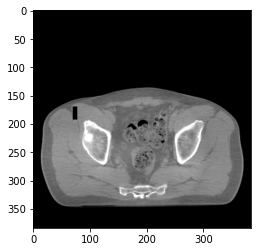

In [26]:
plt.imshow(x.squeeze(), 'gray'),

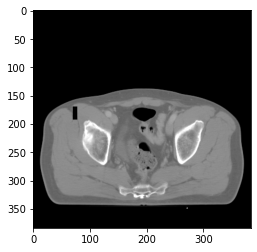

In [27]:
plt.imshow(y.squeeze(), 'gray')

In [28]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [29]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)


In [30]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [31]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [32]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [33]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [34]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [35]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [36]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [03:01,  1.08s/it]
168it [00:57,  2.93it/s]
24it [00:08,  2.92it/s]
168it [02:20,  1.19it/s]
168it [00:56,  2.99it/s]
24it [00:08,  2.89it/s]
168it [02:22,  1.18it/s]
168it [01:00,  2.78it/s]
24it [00:08,  2.79it/s]
168it [02:35,  1.08it/s]
168it [01:02,  2.68it/s]
24it [00:09,  2.58it/s]
168it [02:38,  1.06it/s]
168it [00:54,  3.08it/s]
24it [00:07,  3.05it/s]
168it [02:18,  1.21it/s]
168it [00:55,  3.03it/s]
24it [00:08,  2.97it/s]
168it [02:20,  1.20it/s]
168it [00:59,  2.81it/s]
24it [00:08,  2.75it/s]
168it [02:26,  1.15it/s]
168it [00:54,  3.08it/s]
24it [00:07,  3.00it/s]
168it [02:27,  1.14it/s]
168it [00:58,  2.88it/s]
24it [00:08,  2.77it/s]
168it [02:27,  1.14it/s]
168it [00:58,  2.86it/s]
24it [00:08,  2.87it/s]
168it [02:29,  1.12it/s]
168it [01:00,  2.79it/s]
24it [00:09,  2.66it/s]
168it [02:28,  1.13it/s]
168it [01:08,  2.47it/s]
24it [00:09,  2.41it/s]
168it [02:31,  1.11it/s]
168it [00:56,  2.98it/s]
24it [00:08,  3.00it/s]
168it [02:31,  1.11it/s]
168it [01:05,

In [37]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [38]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [39]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8897278308868408
psnr score = 22.158605575561523
snr score = 12.221545219421387
mae error = 0.04107464477419853
air dice score = 0.9983379392413545
bone dice score = 0.9434628975273341
contour dice score = 0.6304477453231812


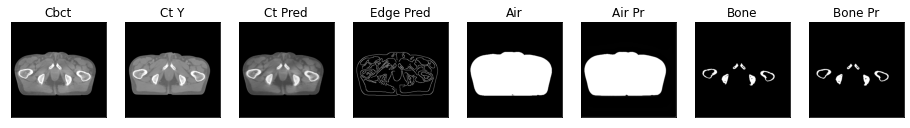

ssim score = 0.8904974460601807
psnr score = 22.056171417236328
snr score = 12.166646957397461
mae error = 0.041720081120729446
air dice score = 0.9982608353885625
bone dice score = 0.9420439463214564
contour dice score = 0.6068222522735596


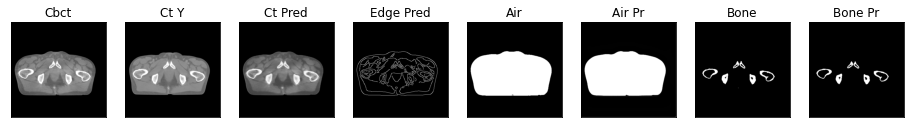

ssim score = 0.8884180188179016
psnr score = 21.488035202026367
snr score = 11.761404037475586
mae error = 0.045268211513757706
air dice score = 0.9981132817106264
bone dice score = 0.9077832006176755
contour dice score = 0.5940119624137878


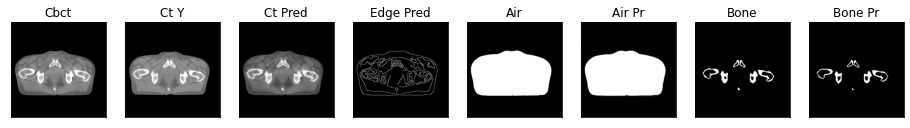

ssim score = 0.8861125111579895
psnr score = 21.270599365234375
snr score = 11.633223533630371
mae error = 0.046677116304636
air dice score = 0.9980306431919355
bone dice score = 0.8736867239747649
contour dice score = 0.662665069103241


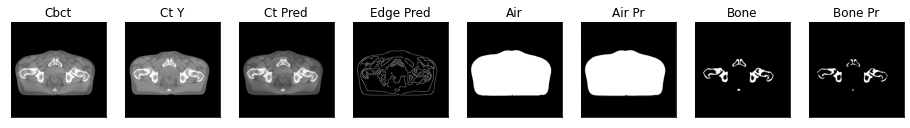

ssim score = 0.8866184949874878
psnr score = 21.198575973510742
snr score = 11.601497650146484
mae error = 0.046841610223054886
air dice score = 0.9979449077184543
bone dice score = 0.8263405878413019
contour dice score = 0.6862980723381042


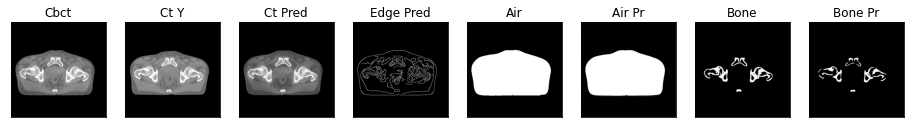

ssim score = 0.8797689080238342
psnr score = 20.72262191772461
snr score = 11.26208209991455
mae error = 0.049643129110336304
air dice score = 0.9978473717103
bone dice score = 0.766171153075872
contour dice score = 0.7064496874809265


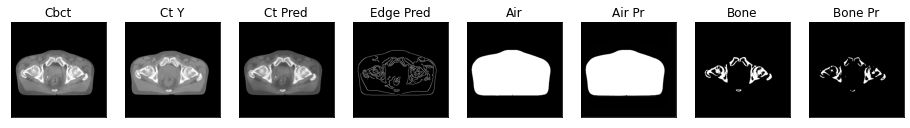

ssim score = 0.8789498209953308
psnr score = 20.68035888671875
snr score = 11.195759773254395
mae error = 0.04945548251271248
air dice score = 0.9977839445786522
bone dice score = 0.7464236723520827
contour dice score = 0.7363966107368469


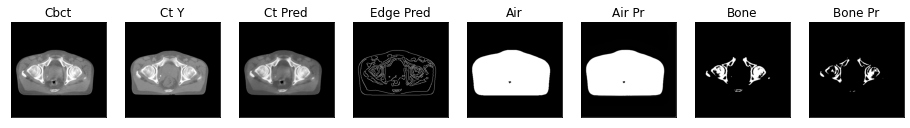

ssim score = 0.8804967403411865
psnr score = 21.223724365234375
snr score = 11.553590774536133
mae error = 0.04635170102119446
air dice score = 0.9978022419139585
bone dice score = 0.8090374497079434
contour dice score = 0.6949666738510132


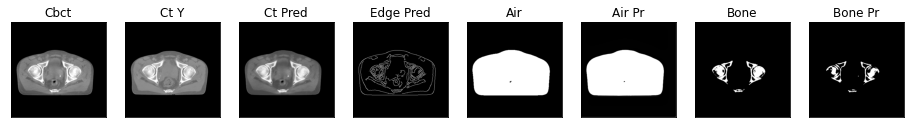

1it [00:03,  3.01s/it]

ssim score = 0.8839935064315796
psnr score = 21.543424606323242
snr score = 11.778732299804688
mae error = 0.04457144811749458
air dice score = 0.9982128974283915
bone dice score = 0.8747742963369647
contour dice score = 0.7113276720046997


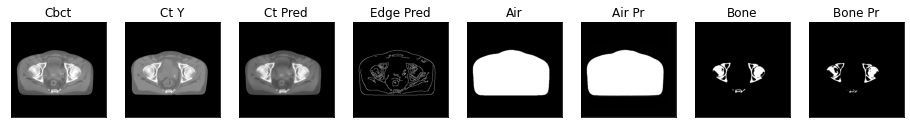

ssim score = 0.8879206776618958
psnr score = 21.499629974365234
snr score = 11.719655990600586
mae error = 0.04464263841509819
air dice score = 0.9980389965352239
bone dice score = 0.8745551601437437
contour dice score = 0.660158634185791


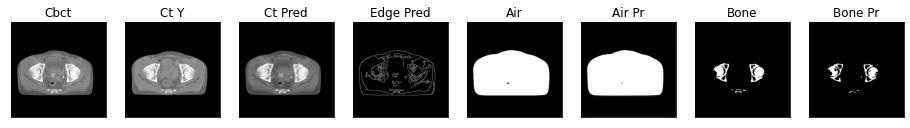

ssim score = 0.8923799395561218
psnr score = 21.425491333007812
snr score = 11.677789688110352
mae error = 0.045268576592206955
air dice score = 0.99814956806216
bone dice score = 0.9044278320885056
contour dice score = 0.6784840822219849


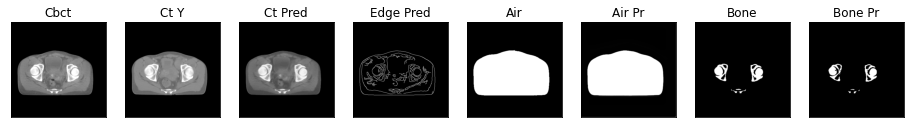

ssim score = 0.8908160328865051
psnr score = 21.048242568969727
snr score = 11.324252128601074
mae error = 0.04660990461707115
air dice score = 0.9980569278789527
bone dice score = 0.8880832651164999
contour dice score = 0.7050183415412903


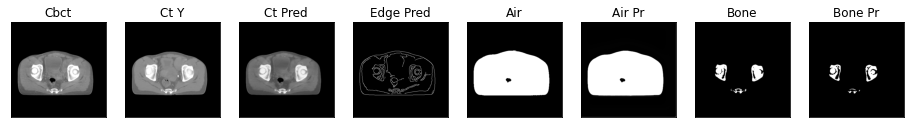

ssim score = 0.8947641849517822
psnr score = 20.82454490661621
snr score = 11.068629264831543
mae error = 0.04699580743908882
air dice score = 0.9979936046147115
bone dice score = 0.9114110429458723
contour dice score = 0.7136725783348083


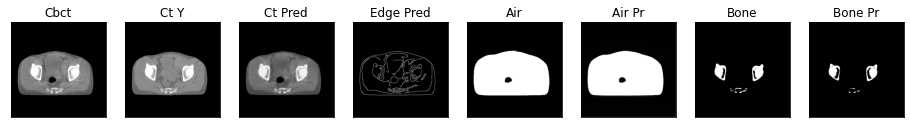

ssim score = 0.8932294845581055
psnr score = 21.119367599487305
snr score = 11.221495628356934
mae error = 0.04425561800599098
air dice score = 0.9976924778994197
bone dice score = 0.89702333065303
contour dice score = 0.6888889074325562


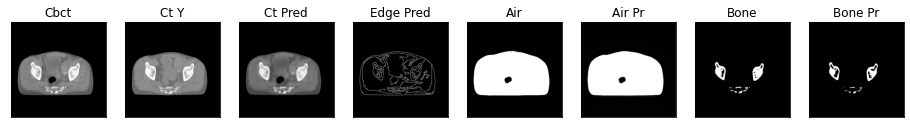

ssim score = 0.8901387453079224
psnr score = 21.232223510742188
snr score = 11.24869155883789
mae error = 0.043134111911058426
air dice score = 0.9969397587809895
bone dice score = 0.8852505694777156
contour dice score = 0.6790123581886292


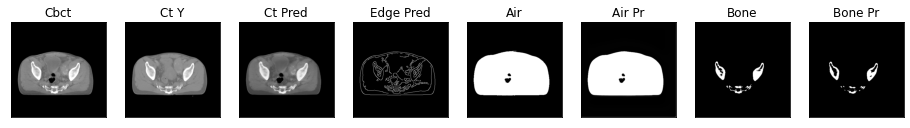

ssim score = 0.8842059373855591
psnr score = 21.138442993164062
snr score = 11.178393363952637
mae error = 0.04384807124733925
air dice score = 0.9960497034615713
bone dice score = 0.8840977753380377
contour dice score = 0.7556390762329102


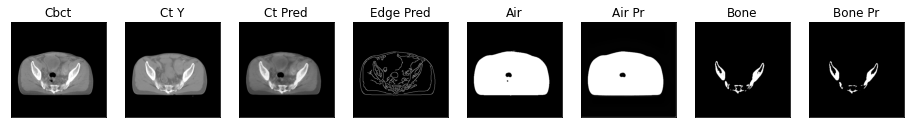

2it [00:05,  2.96s/it]

ssim score = 0.8793599605560303
psnr score = 20.7650089263916
snr score = 10.80241584777832
mae error = 0.045061130076646805
air dice score = 0.9960141336665704
bone dice score = 0.8762778505913987
contour dice score = 0.7308176159858704


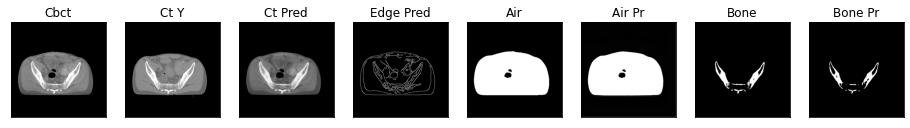

ssim score = 0.872346043586731
psnr score = 20.700702667236328
snr score = 10.636350631713867
mae error = 0.04422130063176155
air dice score = 0.995428322629808
bone dice score = 0.8440217391325541
contour dice score = 0.6935483813285828


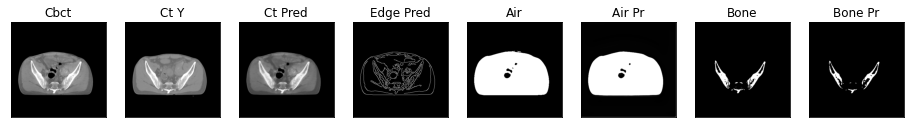

ssim score = 0.8698081374168396
psnr score = 20.70785903930664
snr score = 10.59282398223877
mae error = 0.04381394386291504
air dice score = 0.9945640261277513
bone dice score = 0.8276520316358379
contour dice score = 0.685386061668396


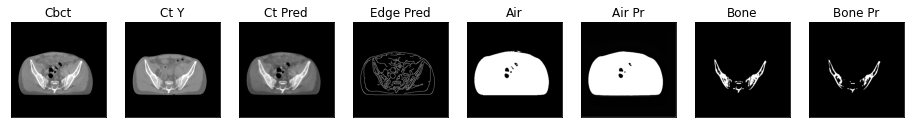

ssim score = 0.8733094334602356
psnr score = 20.80921173095703
snr score = 10.681867599487305
mae error = 0.04358318820595741
air dice score = 0.9952555388825192
bone dice score = 0.8638344226598061
contour dice score = 0.6734305620193481


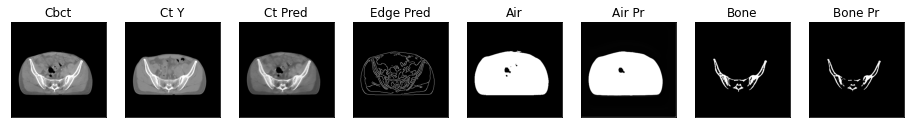

ssim score = 0.8713847398757935
psnr score = 20.848875045776367
snr score = 10.656682014465332
mae error = 0.04304174706339836
air dice score = 0.9970113968374367
bone dice score = 0.8587052911637791
contour dice score = 0.6499999761581421


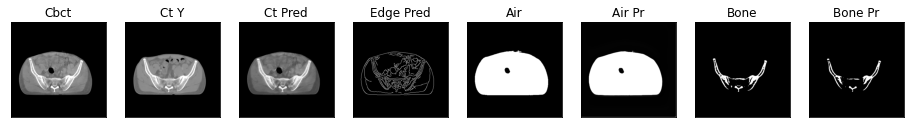

ssim score = 0.8704096674919128
psnr score = 21.003376007080078
snr score = 10.751752853393555
mae error = 0.042451243847608566
air dice score = 0.9958381476952808
bone dice score = 0.8688477127986559
contour dice score = 0.5461587905883789


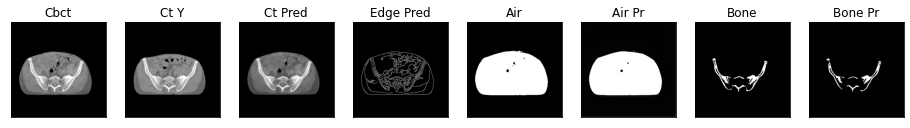

ssim score = 0.8756939768791199
psnr score = 21.15665054321289
snr score = 10.871601104736328
mae error = 0.0418238528072834
air dice score = 0.9954866072441139
bone dice score = 0.8634807613328292
contour dice score = 0.635064959526062


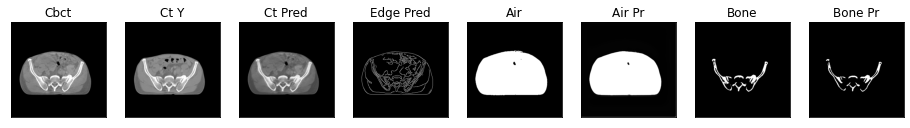

ssim score = 0.8752739429473877
psnr score = 21.240150451660156
snr score = 10.906538963317871
mae error = 0.041025787591934204
air dice score = 0.996172446196516
bone dice score = 0.8336494175042855
contour dice score = 0.6446062326431274


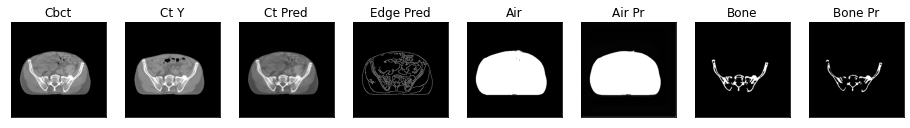

3it [00:08,  2.80s/it]

ssim score = 0.8742867708206177
psnr score = 21.2763671875
snr score = 10.845752716064453
mae error = 0.04022269323468208
air dice score = 0.9956870996617155
bone dice score = 0.8163427211448322
contour dice score = 0.6044325232505798


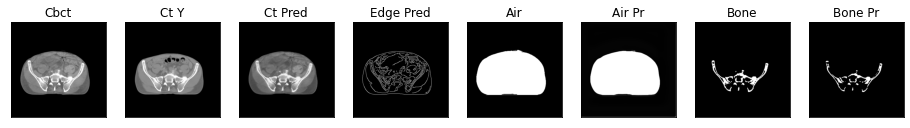

ssim score = 0.8786283731460571
psnr score = 21.492082595825195
snr score = 10.978734970092773
mae error = 0.038896337151527405
air dice score = 0.9952264469090707
bone dice score = 0.7871712292030707
contour dice score = 0.6680272221565247


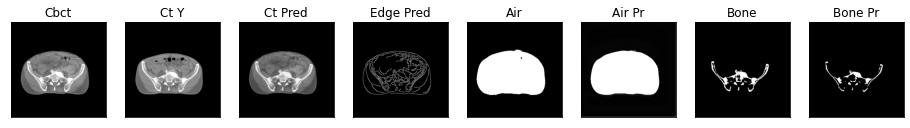

ssim score = 0.8756119012832642
psnr score = 21.606929779052734
snr score = 11.002395629882812
mae error = 0.03780540078878403
air dice score = 0.9942231534073777
bone dice score = 0.7873434410047813
contour dice score = 0.746685266494751


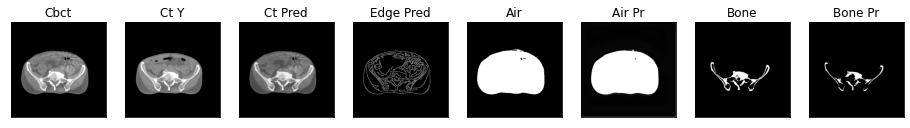

ssim score = 0.8755335807800293
psnr score = 21.495033264160156
snr score = 10.849390983581543
mae error = 0.03800727799534798
air dice score = 0.9892063026391517
bone dice score = 0.78803117928353
contour dice score = 0.7245762944221497


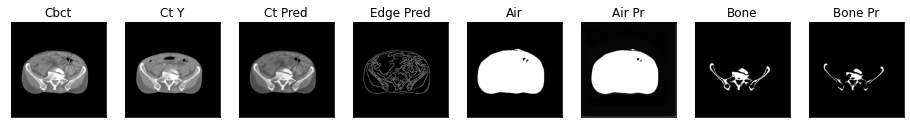

ssim score = 0.8352081179618835
psnr score = 20.27644157409668
snr score = 11.648599624633789
mae error = 0.06090553477406502
air dice score = 0.9973346855732916
bone dice score = 0.9234844025920105
contour dice score = 0.5500848889350891


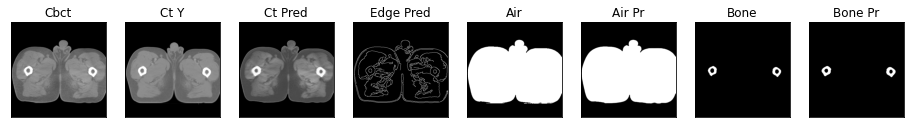

ssim score = 0.8434931039810181
psnr score = 20.498600006103516
snr score = 11.910014152526855
mae error = 0.06048143655061722
air dice score = 0.9967852747212393
bone dice score = 0.9334442595692334
contour dice score = 0.5185497403144836


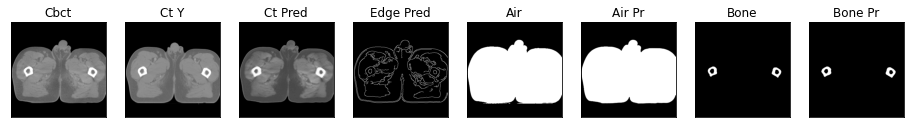

ssim score = 0.8515931963920593
psnr score = 20.544431686401367
snr score = 12.043295860290527
mae error = 0.061873216181993484
air dice score = 0.9966423766134253
bone dice score = 0.9302223200543644
contour dice score = 0.5197339057922363


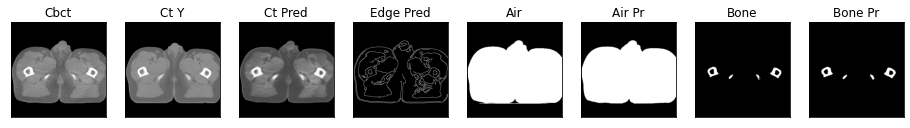

ssim score = 0.8603432774543762
psnr score = 20.184659957885742
snr score = 11.846080780029297
mae error = 0.06682756543159485
air dice score = 0.99780512138344
bone dice score = 0.9454939609794751
contour dice score = 0.5415328145027161


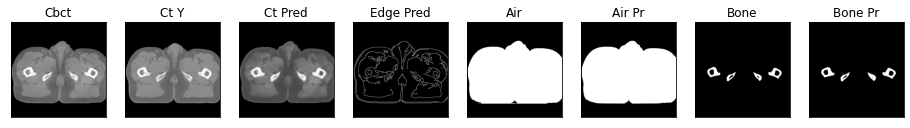

4it [00:10,  2.68s/it]

ssim score = 0.8595345616340637
psnr score = 19.92333984375
snr score = 11.712902069091797
mae error = 0.06954199075698853
air dice score = 0.998339510035136
bone dice score = 0.9377437138639539
contour dice score = 0.5081281661987305


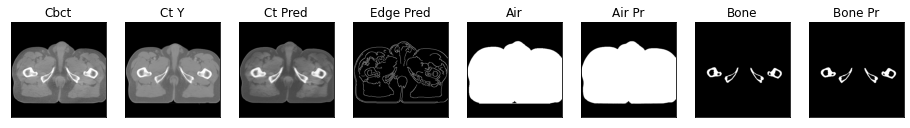

ssim score = 0.8618643283843994
psnr score = 19.72650146484375
snr score = 11.619301795959473
mae error = 0.07175040245056152
air dice score = 0.9984777475458183
bone dice score = 0.9343573742957595
contour dice score = 0.5391061305999756


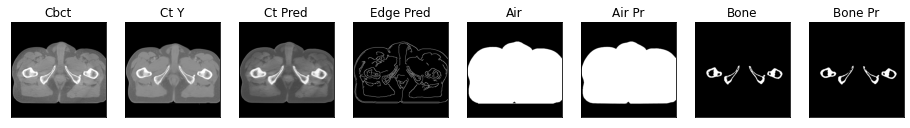

ssim score = 0.8626518249511719
psnr score = 19.62424659729004
snr score = 11.584150314331055
mae error = 0.07297485321760178
air dice score = 0.9985015551588898
bone dice score = 0.9354369475222621
contour dice score = 0.49535316228866577


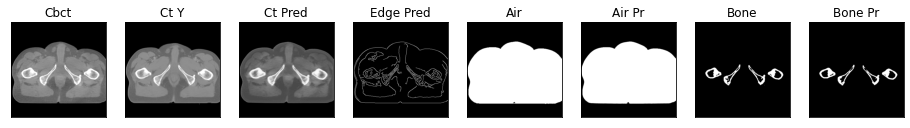

ssim score = 0.8619675636291504
psnr score = 19.716094970703125
snr score = 11.666108131408691
mae error = 0.0723358541727066
air dice score = 0.9985120287595091
bone dice score = 0.9443320915386447
contour dice score = 0.5173530578613281


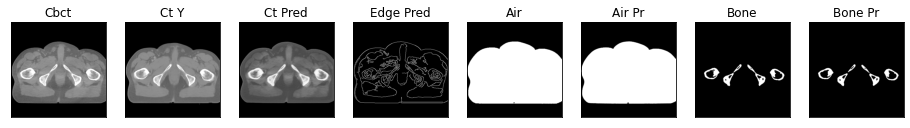

ssim score = 0.8671661615371704
psnr score = 19.816036224365234
snr score = 11.752386093139648
mae error = 0.07187924534082413
air dice score = 0.9985567242987055
bone dice score = 0.9388314701546211
contour dice score = 0.5039370059967041


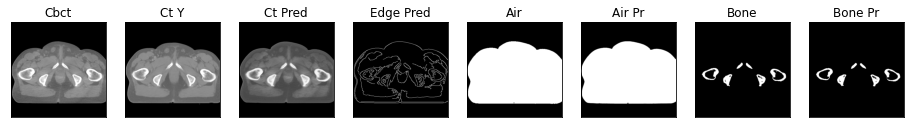

ssim score = 0.8651754856109619
psnr score = 19.82009506225586
snr score = 11.76844596862793
mae error = 0.07205413281917572
air dice score = 0.99862381511668
bone dice score = 0.9377777777784692
contour dice score = 0.5275846123695374


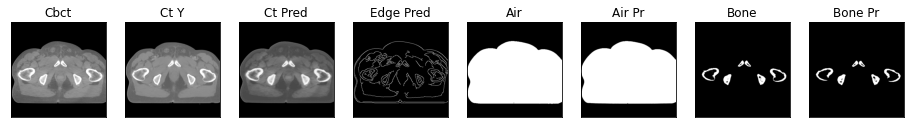

ssim score = 0.8630131483078003
psnr score = 19.697959899902344
snr score = 11.685394287109375
mae error = 0.07301326841115952
air dice score = 0.9987370518164522
bone dice score = 0.9335309542819116
contour dice score = 0.5214152932167053


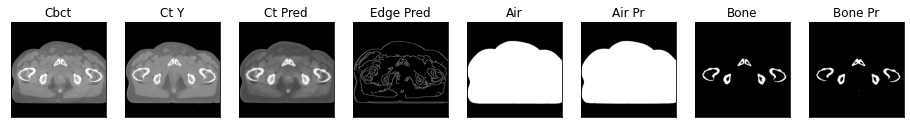

ssim score = 0.8628719449043274
psnr score = 19.297334671020508
snr score = 11.426056861877441
mae error = 0.07657241821289062
air dice score = 0.9986895083580911
bone dice score = 0.9190380761531158
contour dice score = 0.520074725151062


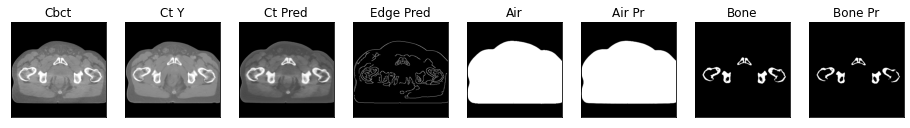

5it [00:13,  2.76s/it]

ssim score = 0.8631288409233093
psnr score = 19.036163330078125
snr score = 11.259573936462402
mae error = 0.07881838828325272
air dice score = 0.998865937145606
bone dice score = 0.8876531410210474
contour dice score = 0.4850187301635742


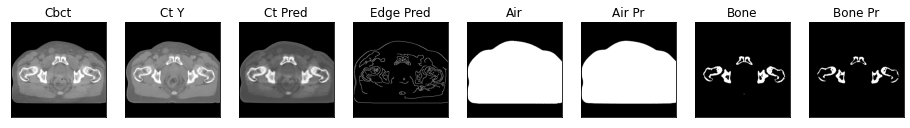

ssim score = 0.851165771484375
psnr score = 18.92667007446289
snr score = 11.116032600402832
mae error = 0.07879114151000977
air dice score = 0.9986237794234181
bone dice score = 0.8427103292123087
contour dice score = 0.5154638886451721


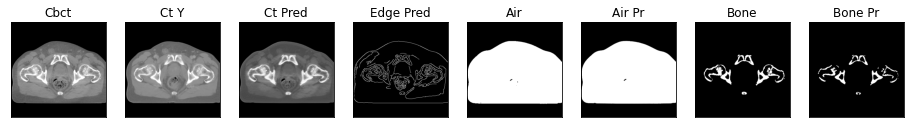

ssim score = 0.8498774766921997
psnr score = 18.630464553833008
snr score = 10.89201545715332
mae error = 0.08074978739023209
air dice score = 0.9982381916895393
bone dice score = 0.7669256381816479
contour dice score = 0.5011775493621826


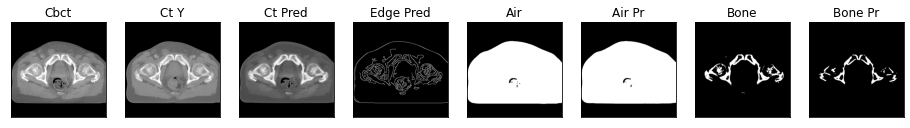

ssim score = 0.8506278395652771
psnr score = 18.919546127319336
snr score = 11.044999122619629
mae error = 0.07784724235534668
air dice score = 0.9984307264954705
bone dice score = 0.8307722045053564
contour dice score = 0.5179245471954346


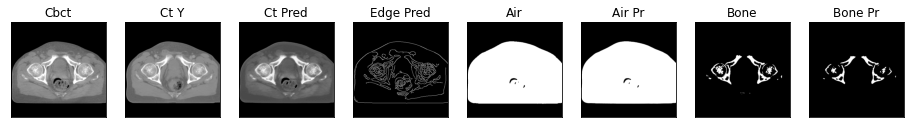

ssim score = 0.8547511696815491
psnr score = 19.386369705200195
snr score = 11.333263397216797
mae error = 0.07360515743494034
air dice score = 0.9984740191199986
bone dice score = 0.8780337941640755
contour dice score = 0.5518220663070679


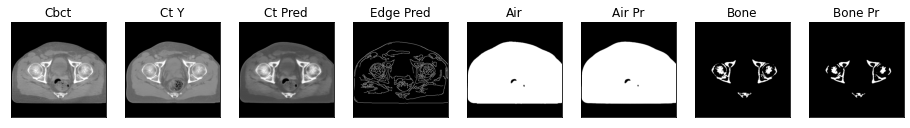

ssim score = 0.8544538021087646
psnr score = 19.748184204101562
snr score = 11.604488372802734
mae error = 0.0708485022187233
air dice score = 0.9986349029935498
bone dice score = 0.8837367111526381
contour dice score = 0.5715644359588623


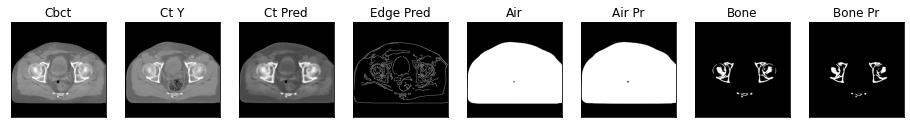

ssim score = 0.855027973651886
psnr score = 19.769432067871094
snr score = 11.641427040100098
mae error = 0.07066570222377777
air dice score = 0.9987441073151206
bone dice score = 0.8905982905994594
contour dice score = 0.5831348299980164


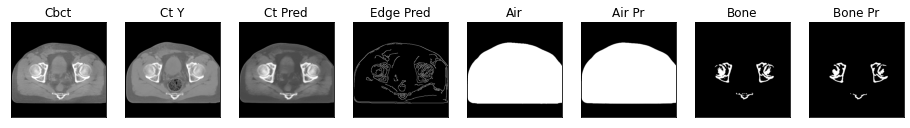

ssim score = 0.8446621298789978
psnr score = 19.727916717529297
snr score = 11.609947204589844
mae error = 0.07111180573701859
air dice score = 0.998700863041689
bone dice score = 0.8778084351608415
contour dice score = 0.5639312863349915


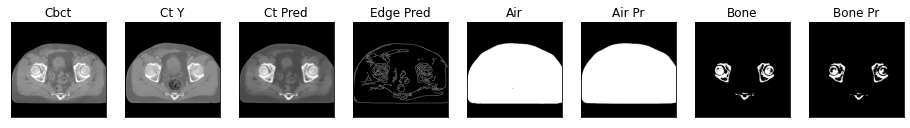

6it [00:16,  2.67s/it]

ssim score = 0.8534088134765625
psnr score = 19.728212356567383
snr score = 11.671833038330078
mae error = 0.07143495231866837
air dice score = 0.9986350587904058
bone dice score = 0.8788765359871379
contour dice score = 0.557939887046814


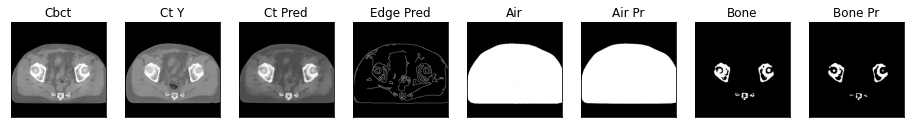

ssim score = 0.8554056286811829
psnr score = 19.543033599853516
snr score = 11.556735038757324
mae error = 0.07311263680458069
air dice score = 0.9984419089682257
bone dice score = 0.9121892168738971
contour dice score = 0.5300285816192627


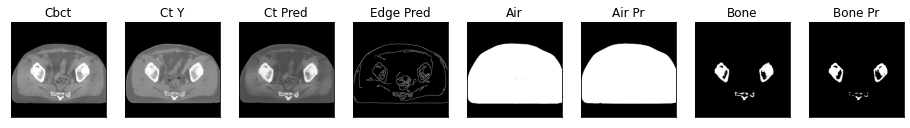

ssim score = 0.8627680540084839
psnr score = 19.8142032623291
snr score = 11.708799362182617
mae error = 0.07021840661764145
air dice score = 0.998546253074645
bone dice score = 0.9065786760166367
contour dice score = 0.5516912937164307


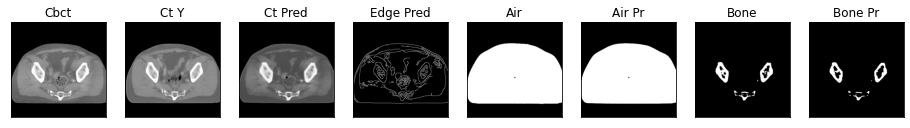

ssim score = 0.8581464290618896
psnr score = 19.540912628173828
snr score = 11.517135620117188
mae error = 0.07256361842155457
air dice score = 0.9981118195193734
bone dice score = 0.9001719612643663
contour dice score = 0.5236955285072327


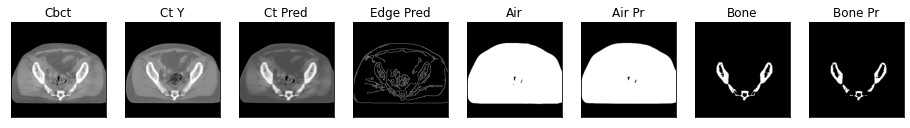

ssim score = 0.8562223315238953
psnr score = 19.339969635009766
snr score = 11.396340370178223
mae error = 0.07465784251689911
air dice score = 0.9980053842388656
bone dice score = 0.8433734939771533
contour dice score = 0.455331414937973


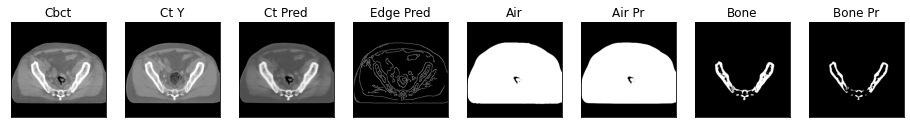

ssim score = 0.8416333198547363
psnr score = 19.163972854614258
snr score = 11.241901397705078
mae error = 0.0757284164428711
air dice score = 0.9980344760230503
bone dice score = 0.8286478165775853
contour dice score = 0.45108434557914734


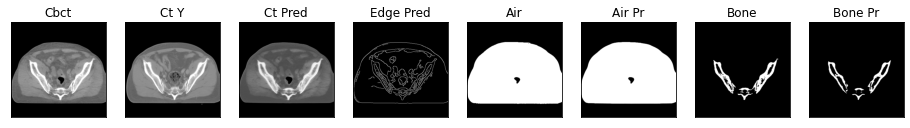

ssim score = 0.8439918160438538
psnr score = 19.300662994384766
snr score = 11.391129493713379
mae error = 0.07495585829019547
air dice score = 0.9979718725972757
bone dice score = 0.851795078661946
contour dice score = 0.4090471565723419


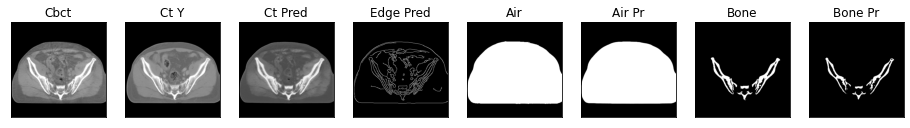

ssim score = 0.7879332304000854
psnr score = 19.629653930664062
snr score = 9.509862899780273
mae error = 0.05112147331237793
air dice score = 0.997502942960085
bone dice score = 0.935708752906385
contour dice score = 0.6394257545471191


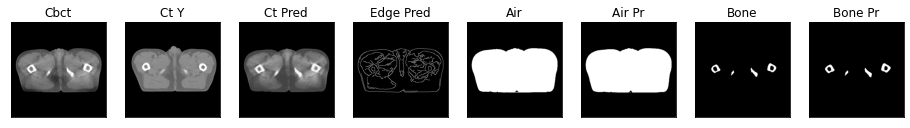

7it [00:18,  2.62s/it]

ssim score = 0.779053270816803
psnr score = 19.205589294433594
snr score = 9.298779487609863
mae error = 0.054716017097234726
air dice score = 0.9977480672388133
bone dice score = 0.9174537987696622
contour dice score = 0.6443100571632385


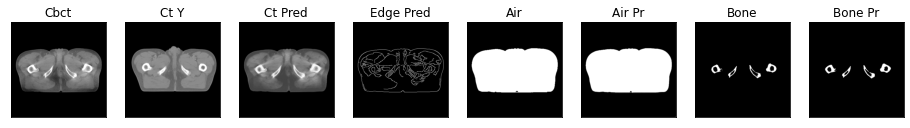

ssim score = 0.7764344215393066
psnr score = 19.10663414001465
snr score = 9.330961227416992
mae error = 0.05615855008363724
air dice score = 0.9979713519616162
bone dice score = 0.8981642512096973
contour dice score = 0.6524356603622437


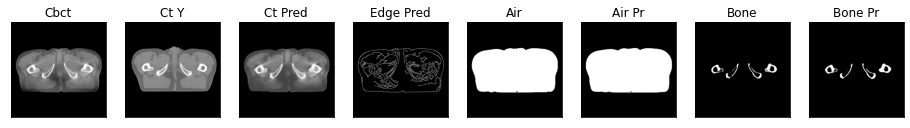

ssim score = 0.780238687992096
psnr score = 19.238950729370117
snr score = 9.533679962158203
mae error = 0.056067824363708496
air dice score = 0.9977721252521728
bone dice score = 0.8937037037056722
contour dice score = 0.5769020318984985


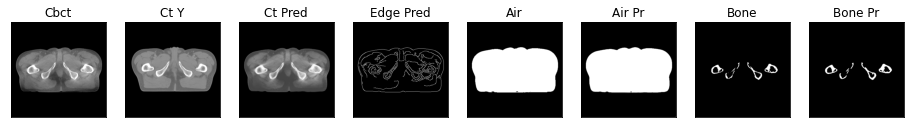

ssim score = 0.7806575894355774
psnr score = 19.24134063720703
snr score = 9.583638191223145
mae error = 0.05637427791953087
air dice score = 0.9971946689971621
bone dice score = 0.8949079089943137
contour dice score = 0.5538628697395325


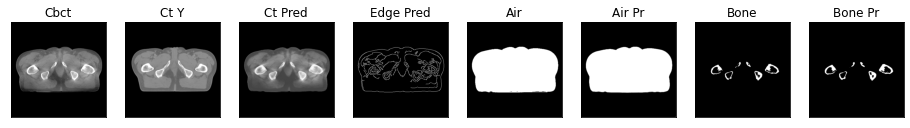

ssim score = 0.7794842720031738
psnr score = 19.377845764160156
snr score = 9.725759506225586
mae error = 0.05558047816157341
air dice score = 0.9968825650046179
bone dice score = 0.9084171519338553
contour dice score = 0.5594480037689209


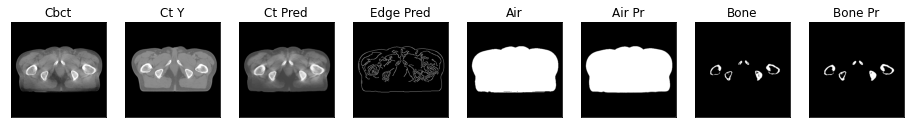

ssim score = 0.782796323299408
psnr score = 19.479766845703125
snr score = 9.82117748260498
mae error = 0.055115681141614914
air dice score = 0.9972135174784528
bone dice score = 0.9076536112125826
contour dice score = 0.577659547328949


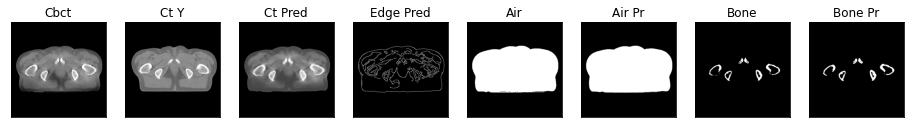

ssim score = 0.7818565368652344
psnr score = 19.384567260742188
snr score = 9.740086555480957
mae error = 0.05625211074948311
air dice score = 0.9973955404037368
bone dice score = 0.9080097936357466
contour dice score = 0.5774946808815002


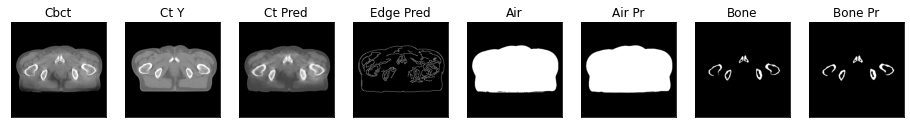

ssim score = 0.7804405689239502
psnr score = 19.223052978515625
snr score = 9.636579513549805
mae error = 0.058143775910139084
air dice score = 0.9969319586203347
bone dice score = 0.9044303797483476
contour dice score = 0.5883609056472778


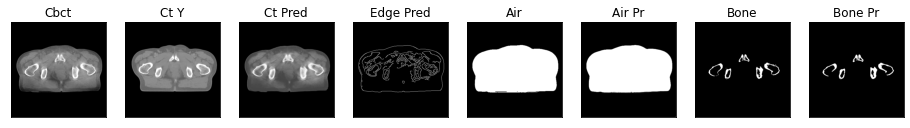

8it [00:21,  2.69s/it]

ssim score = 0.7756214141845703
psnr score = 19.03662109375
snr score = 9.548707962036133
mae error = 0.060360804200172424
air dice score = 0.9967330120938921
bone dice score = 0.8885823754806348
contour dice score = 0.5614776015281677


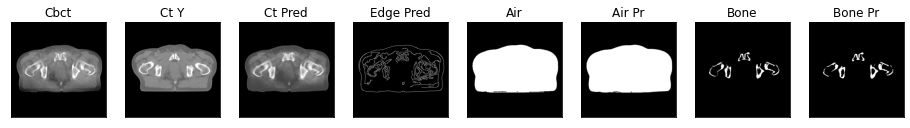

ssim score = 0.7668693661689758
psnr score = 18.868154525756836
snr score = 9.416069984436035
mae error = 0.061735231429338455
air dice score = 0.9965645798713685
bone dice score = 0.8849961919286368
contour dice score = 0.5439913868904114


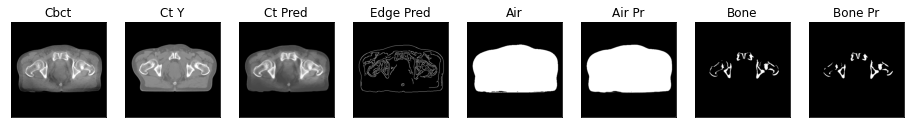

ssim score = 0.7590690851211548
psnr score = 18.72881507873535
snr score = 9.309435844421387
mae error = 0.06284217536449432
air dice score = 0.9968853784867441
bone dice score = 0.8424085278040564
contour dice score = 0.5952890515327454


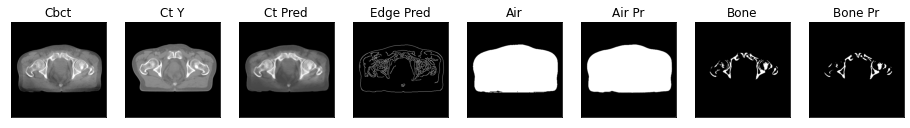

ssim score = 0.758043646812439
psnr score = 18.6629695892334
snr score = 9.360407829284668
mae error = 0.06300180405378342
air dice score = 0.9970582669579753
bone dice score = 0.8871228448291066
contour dice score = 0.6578808426856995


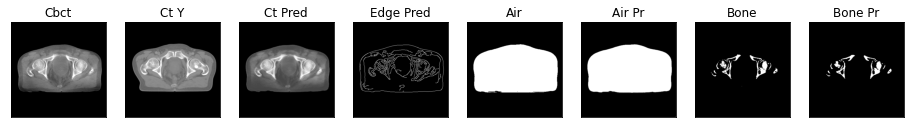

ssim score = 0.761854887008667
psnr score = 18.679794311523438
snr score = 9.361246109008789
mae error = 0.06170080229640007
air dice score = 0.9975579555616724
bone dice score = 0.8861512319472366
contour dice score = 0.6416530609130859


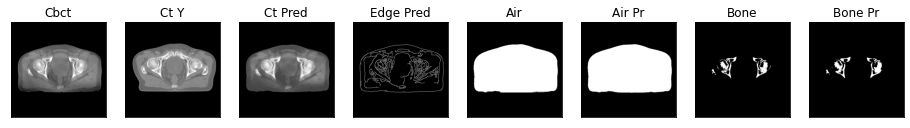

ssim score = 0.7753932476043701
psnr score = 19.194549560546875
snr score = 9.676838874816895
mae error = 0.057253796607255936
air dice score = 0.9977231134061384
bone dice score = 0.9057214296233899
contour dice score = 0.6491416096687317


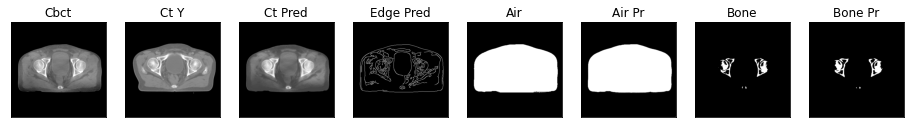

ssim score = 0.7939463257789612
psnr score = 19.77866554260254
snr score = 10.090561866760254
mae error = 0.05365040525794029
air dice score = 0.9975720033974814
bone dice score = 0.9370089593392555
contour dice score = 0.6207638382911682


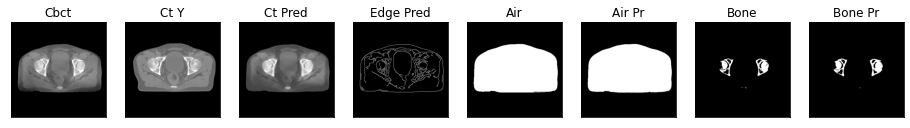

ssim score = 0.8032158017158508
psnr score = 20.010435104370117
snr score = 10.33650016784668
mae error = 0.05251039192080498
air dice score = 0.9972780497825887
bone dice score = 0.9398099260831598
contour dice score = 0.6107848286628723


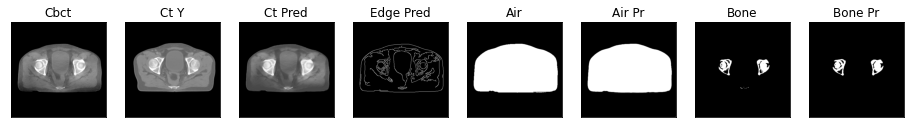

9it [00:23,  2.61s/it]

ssim score = 0.8075653910636902
psnr score = 20.017276763916016
snr score = 10.425168991088867
mae error = 0.0530228428542614
air dice score = 0.9976685198944448
bone dice score = 0.9539760348590145
contour dice score = 0.6199783086776733


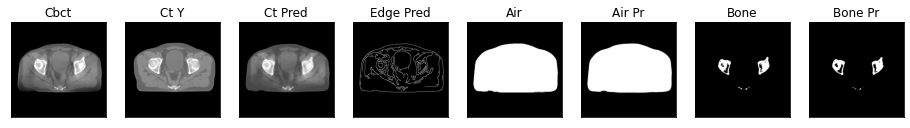

ssim score = 0.8065524697303772
psnr score = 20.035085678100586
snr score = 10.535150527954102
mae error = 0.052432794123888016
air dice score = 0.9976575210610172
bone dice score = 0.9366495976600344
contour dice score = 0.6248624920845032


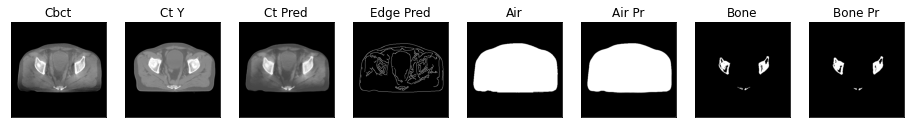

ssim score = 0.7992033958435059
psnr score = 20.210302352905273
snr score = 10.646942138671875
mae error = 0.0513308048248291
air dice score = 0.9971995926680268
bone dice score = 0.9470967741944016
contour dice score = 0.6176943778991699


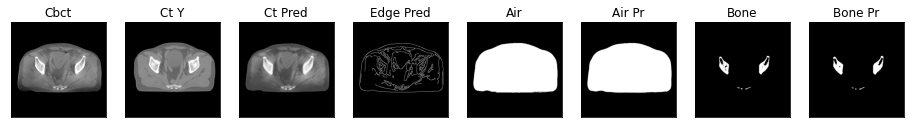

ssim score = 0.8027489185333252
psnr score = 20.34036636352539
snr score = 10.740612030029297
mae error = 0.050498541444540024
air dice score = 0.997320807827313
bone dice score = 0.9370268410196657
contour dice score = 0.5945658087730408


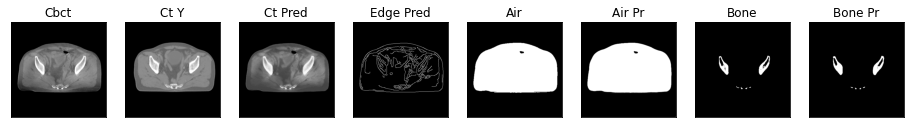

ssim score = 0.8005281090736389
psnr score = 20.01077651977539
snr score = 10.448768615722656
mae error = 0.05306887626647949
air dice score = 0.997167282966383
bone dice score = 0.9274141283226278
contour dice score = 0.6323607563972473


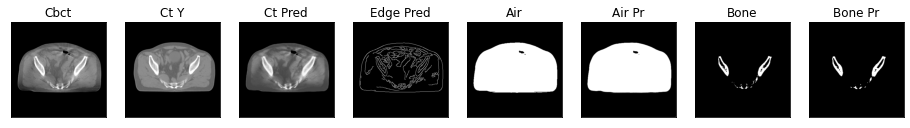

ssim score = 0.7993835806846619
psnr score = 19.84889030456543
snr score = 10.417386054992676
mae error = 0.05460475757718086
air dice score = 0.9971224120807787
bone dice score = 0.9249205890856927
contour dice score = 0.6303418874740601


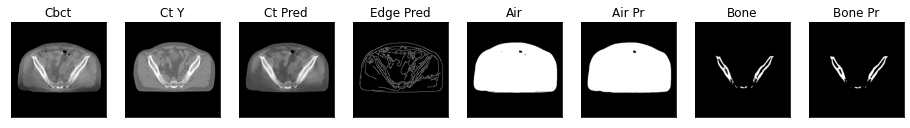

ssim score = 0.801333487033844
psnr score = 19.795047760009766
snr score = 10.381290435791016
mae error = 0.05432765558362007
air dice score = 0.9973167054253683
bone dice score = 0.8948609146645472
contour dice score = 0.6104245185852051


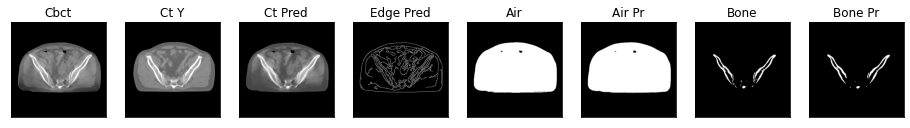

ssim score = 0.8046401143074036
psnr score = 20.03363609313965
snr score = 10.608611106872559
mae error = 0.05280305817723274
air dice score = 0.9970917800017132
bone dice score = 0.8930463576176648
contour dice score = 0.6033459305763245


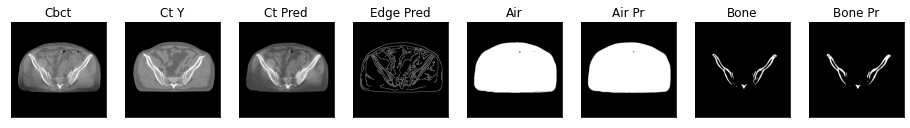

10it [00:26,  2.54s/it]

ssim score = 0.8073906302452087
psnr score = 20.069303512573242
snr score = 10.643537521362305
mae error = 0.052414048463106155
air dice score = 0.9970289207941222
bone dice score = 0.891754218403506
contour dice score = 0.5925925970077515


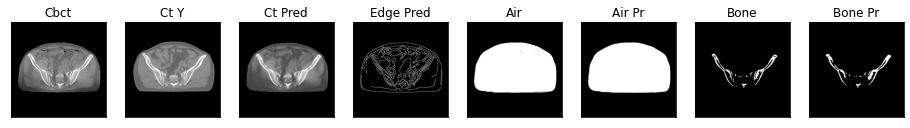

ssim score = 0.8485069870948792
psnr score = 21.032291412353516
snr score = 11.466423034667969
mae error = 0.04630791023373604
air dice score = 0.9973411030442003
bone dice score = 0.8436578171142688
contour dice score = 0.5042462944984436


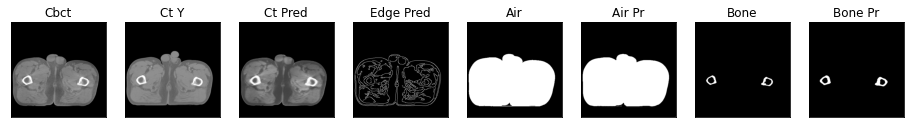

ssim score = 0.8492408990859985
psnr score = 21.030380249023438
snr score = 11.528907775878906
mae error = 0.047151822596788406
air dice score = 0.9972165111497728
bone dice score = 0.8368200836868852
contour dice score = 0.4797900319099426


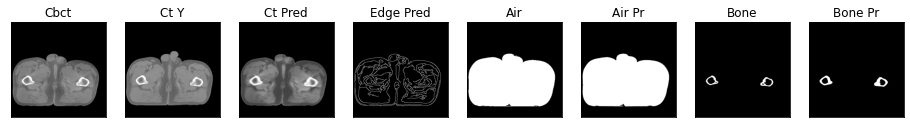

ssim score = 0.8594745397567749
psnr score = 21.123756408691406
snr score = 11.761495590209961
mae error = 0.05056460574269295
air dice score = 0.9982186664999936
bone dice score = 0.8732225115186617
contour dice score = 0.5363128781318665


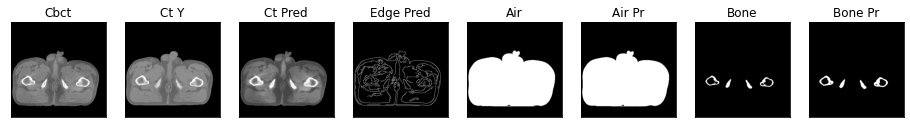

ssim score = 0.8591963648796082
psnr score = 20.912063598632812
snr score = 11.671295166015625
mae error = 0.05239719897508621
air dice score = 0.9986627482079281
bone dice score = 0.8392824116915243
contour dice score = 0.5806783437728882


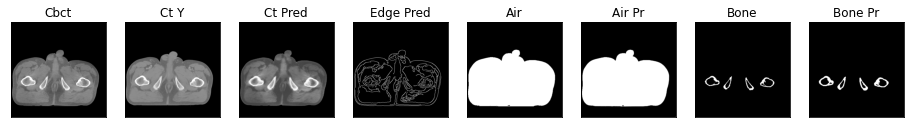

ssim score = 0.8560786843299866
psnr score = 20.880393981933594
snr score = 11.663799285888672
mae error = 0.052525050938129425
air dice score = 0.9986424742651918
bone dice score = 0.8195048195082308
contour dice score = 0.6192945837974548


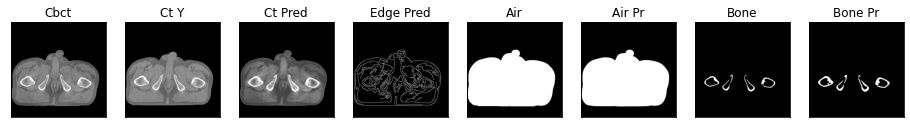

ssim score = 0.8568504452705383
psnr score = 20.84960174560547
snr score = 11.628609657287598
mae error = 0.053031075745821
air dice score = 0.9986054511365584
bone dice score = 0.8252109523019595
contour dice score = 0.5977011322975159


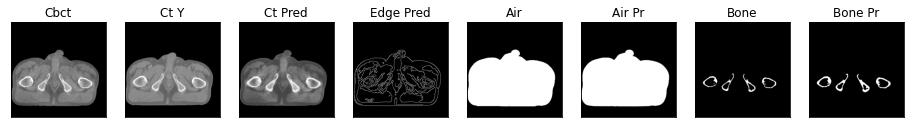

ssim score = 0.8574517965316772
psnr score = 20.74969482421875
snr score = 11.534956932067871
mae error = 0.05369722843170166
air dice score = 0.9983429863412532
bone dice score = 0.8345225959932973
contour dice score = 0.5657203197479248


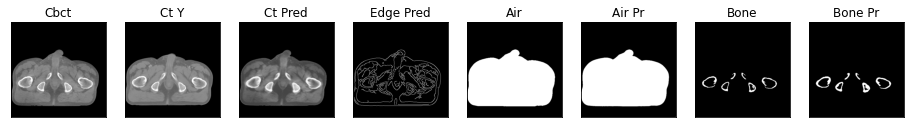

11it [00:29,  2.64s/it]

ssim score = 0.8548455834388733
psnr score = 20.740278244018555
snr score = 11.503981590270996
mae error = 0.05362207815051079
air dice score = 0.9984652352530824
bone dice score = 0.8446486302561741
contour dice score = 0.578199028968811


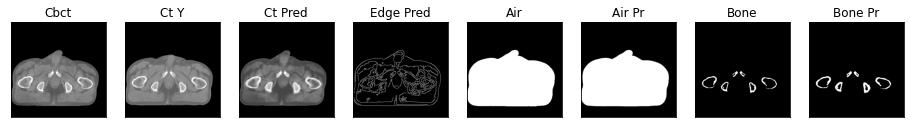

ssim score = 0.8548296093940735
psnr score = 20.7182674407959
snr score = 11.498881340026855
mae error = 0.053611140698194504
air dice score = 0.9982742537313446
bone dice score = 0.8693641618518685
contour dice score = 0.5593220591545105


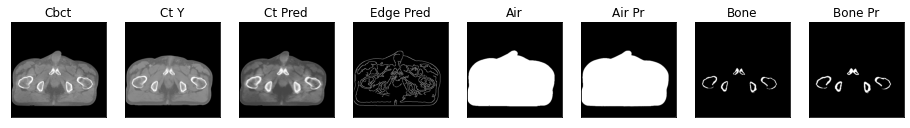

ssim score = 0.8563947677612305
psnr score = 20.6168270111084
snr score = 11.466034889221191
mae error = 0.054566074162721634
air dice score = 0.9981190537513576
bone dice score = 0.8744865358302983
contour dice score = 0.625400185585022


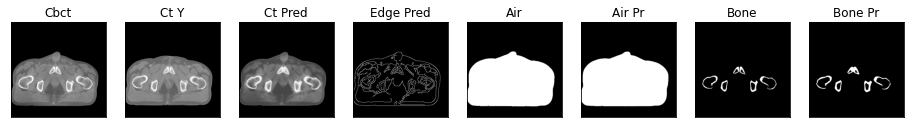

ssim score = 0.8571985960006714
psnr score = 20.437891006469727
snr score = 11.368459701538086
mae error = 0.055859751999378204
air dice score = 0.9982682286565072
bone dice score = 0.8803773045608064
contour dice score = 0.6283566355705261


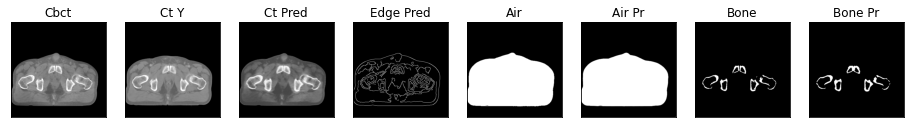

ssim score = 0.8579655289649963
psnr score = 20.383207321166992
snr score = 11.36447811126709
mae error = 0.05636386200785637
air dice score = 0.9986155467803607
bone dice score = 0.8787204450642737
contour dice score = 0.7103707790374756


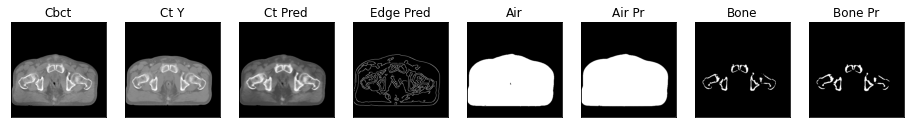

ssim score = 0.8609541654586792
psnr score = 20.16748809814453
snr score = 11.26502799987793
mae error = 0.05783902481198311
air dice score = 0.9988481262327426
bone dice score = 0.867770838991749
contour dice score = 0.6874663829803467


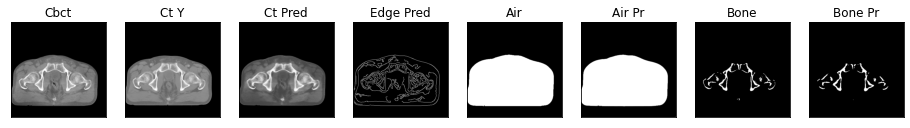

ssim score = 0.8604730367660522
psnr score = 20.126211166381836
snr score = 11.185516357421875
mae error = 0.057183053344488144
air dice score = 0.9989926790770728
bone dice score = 0.8632885809172327
contour dice score = 0.6620021462440491


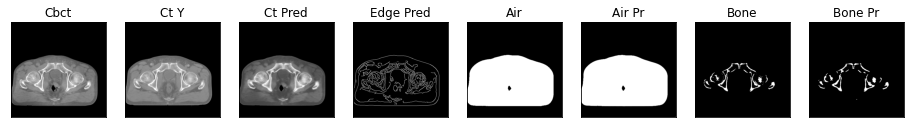

ssim score = 0.8552289009094238
psnr score = 20.018096923828125
snr score = 10.981729507446289
mae error = 0.057372741401195526
air dice score = 0.9986170731512357
bone dice score = 0.8681884153599658
contour dice score = 0.6256741881370544


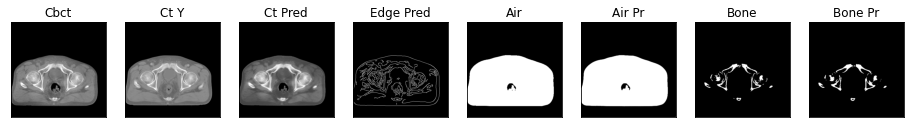

12it [00:31,  2.57s/it]

ssim score = 0.8609362840652466
psnr score = 20.32248306274414
snr score = 11.12635612487793
mae error = 0.05463893339037895
air dice score = 0.9987039019795694
bone dice score = 0.852989659825371
contour dice score = 0.6363636255264282


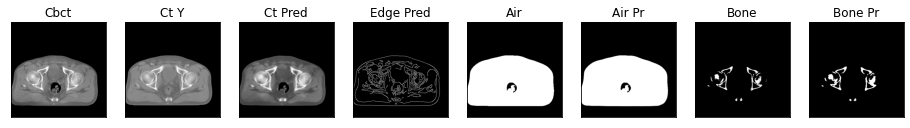

ssim score = 0.8614403009414673
psnr score = 20.41191291809082
snr score = 11.099363327026367
mae error = 0.05318392068147659
air dice score = 0.9984216863549104
bone dice score = 0.8447675299129976
contour dice score = 0.606521725654602


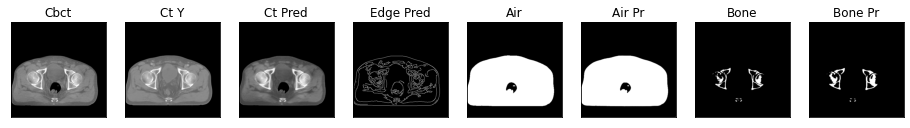

ssim score = 0.8578715324401855
psnr score = 20.531478881835938
snr score = 11.173831939697266
mae error = 0.0520634800195694
air dice score = 0.9986323694404191
bone dice score = 0.8814206046392512
contour dice score = 0.6005449295043945


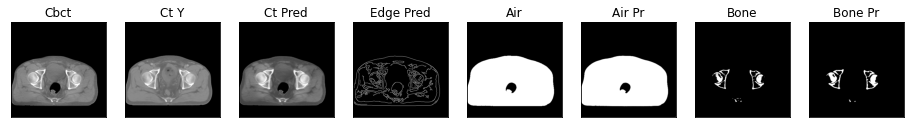

ssim score = 0.8507303595542908
psnr score = 20.37647247314453
snr score = 11.02549934387207
mae error = 0.05244634300470352
air dice score = 0.9986383844349307
bone dice score = 0.9050346698838554
contour dice score = 0.5690879225730896


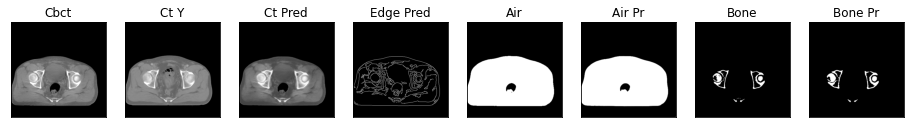

ssim score = 0.8535916805267334
psnr score = 20.22203826904297
snr score = 10.901172637939453
mae error = 0.05313613638281822
air dice score = 0.998652357552551
bone dice score = 0.9269311064729059
contour dice score = 0.5711159706115723


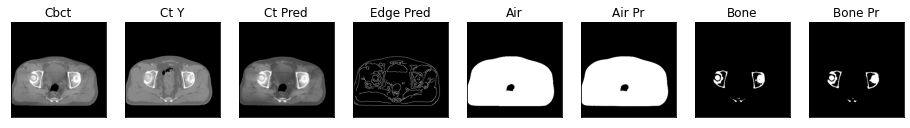

ssim score = 0.8591305613517761
psnr score = 20.653034210205078
snr score = 11.289579391479492
mae error = 0.05159416422247887
air dice score = 0.9986214592838164
bone dice score = 0.9146401175140421
contour dice score = 0.525739312171936


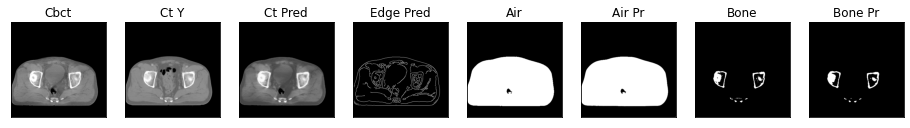

ssim score = 0.8585606813430786
psnr score = 21.010038375854492
snr score = 11.556378364562988
mae error = 0.049198415130376816
air dice score = 0.9985168583764555
bone dice score = 0.8860627177720198
contour dice score = 0.5049288272857666


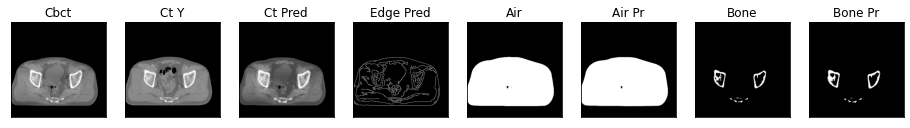

ssim score = 0.8608347773551941
psnr score = 21.0049991607666
snr score = 11.485615730285645
mae error = 0.04830300062894821
air dice score = 0.9984510842410326
bone dice score = 0.9057717130756818
contour dice score = 0.5579351782798767


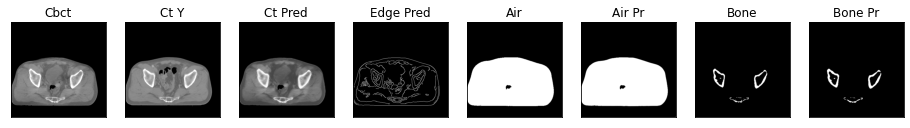

13it [00:33,  2.52s/it]

ssim score = 0.8603640794754028
psnr score = 21.00754737854004
snr score = 11.487860679626465
mae error = 0.048503100872039795
air dice score = 0.9979699008439189
bone dice score = 0.9226675536350796
contour dice score = 0.5566556453704834


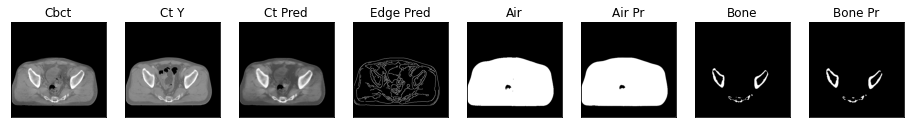

ssim score = 0.8557165265083313
psnr score = 20.697307586669922
snr score = 11.253787994384766
mae error = 0.05070262774825096
air dice score = 0.9979587861129715
bone dice score = 0.9201931269537036
contour dice score = 0.6254143714904785


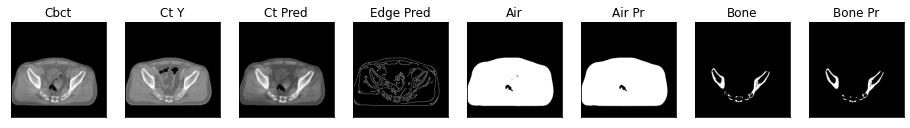

ssim score = 0.8600451946258545
psnr score = 20.754549026489258
snr score = 11.346611976623535
mae error = 0.050551194697618484
air dice score = 0.9981501845553213
bone dice score = 0.9078167115915389
contour dice score = 0.6265193223953247


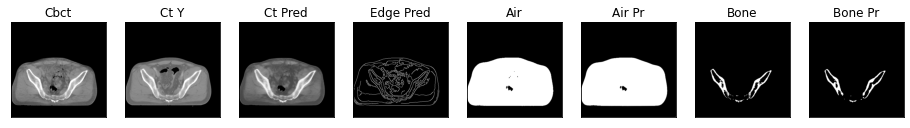

ssim score = 0.8614310622215271
psnr score = 21.150592803955078
snr score = 11.680956840515137
mae error = 0.048353563994169235
air dice score = 0.9982430729938908
bone dice score = 0.8918804024388284
contour dice score = 0.635254979133606


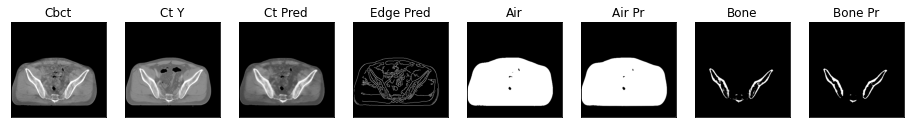

ssim score = 0.854019045829773
psnr score = 21.11675262451172
snr score = 11.585854530334473
mae error = 0.04784971848130226
air dice score = 0.9979444127757355
bone dice score = 0.8891200951264994
contour dice score = 0.5845464468002319


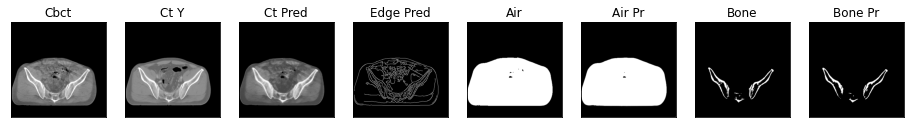

ssim score = 0.7621602416038513
psnr score = 18.926427841186523
snr score = 10.623732566833496
mae error = 0.07214292138814926
air dice score = 0.998480521707256
bone dice score = 0.8995708154535172
contour dice score = 0.6042402982711792


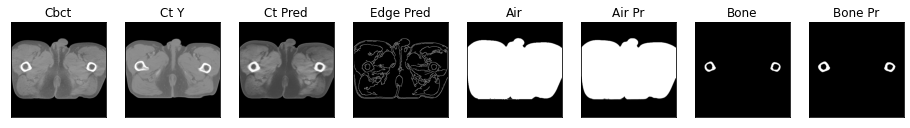

ssim score = 0.7548936009407043
psnr score = 18.582117080688477
snr score = 10.38371467590332
mae error = 0.0758473351597786
air dice score = 0.9983712684702281
bone dice score = 0.8962167689188084
contour dice score = 0.6062222123146057


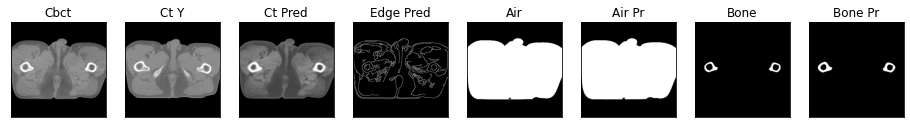

ssim score = 0.7525190114974976
psnr score = 18.141582489013672
snr score = 10.071136474609375
mae error = 0.08063356578350067
air dice score = 0.9985468693237092
bone dice score = 0.8699497487463327
contour dice score = 0.5944494009017944


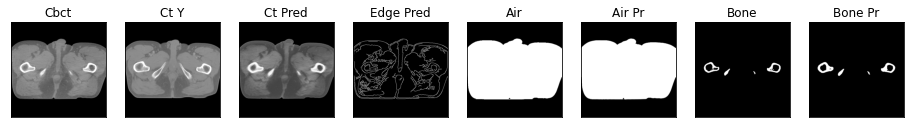

14it [00:36,  2.64s/it]

ssim score = 0.7508797645568848
psnr score = 17.827316284179688
snr score = 9.78915786743164
mae error = 0.08495604246854782
air dice score = 0.998720158957427
bone dice score = 0.8959679901524166
contour dice score = 0.5648854970932007


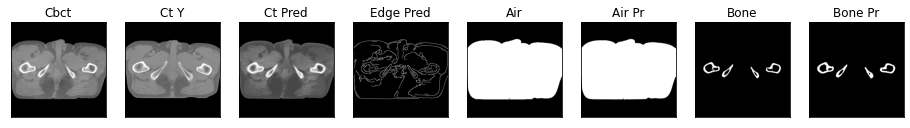

ssim score = 0.7406184673309326
psnr score = 17.743379592895508
snr score = 9.735461235046387
mae error = 0.08584193140268326
air dice score = 0.9986594080412211
bone dice score = 0.8747002398100314
contour dice score = 0.5639403462409973


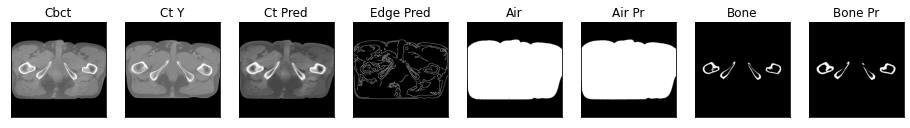

ssim score = 0.7336140871047974
psnr score = 17.615009307861328
snr score = 9.64150619506836
mae error = 0.08695469796657562
air dice score = 0.9986171634419856
bone dice score = 0.8906589427966596
contour dice score = 0.5759493708610535


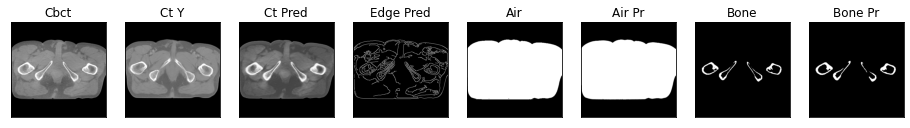

ssim score = 0.7267646789550781
psnr score = 17.396955490112305
snr score = 9.443763732910156
mae error = 0.08938892185688019
air dice score = 0.9986975020984696
bone dice score = 0.8989230569625156
contour dice score = 0.5768364071846008


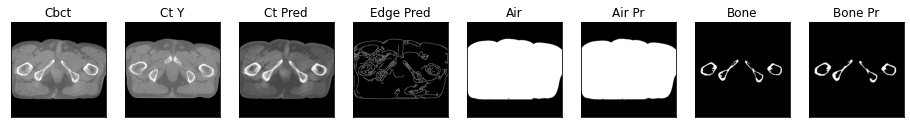

ssim score = 0.7268545031547546
psnr score = 17.361127853393555
snr score = 9.447010040283203
mae error = 0.09043693542480469
air dice score = 0.9982723054610181
bone dice score = 0.9066012143146027
contour dice score = 0.6206278204917908


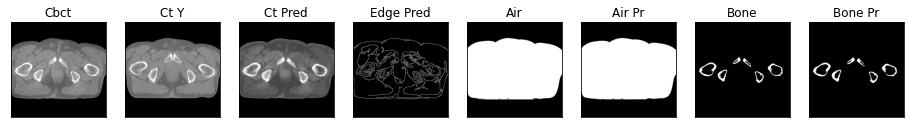

ssim score = 0.7262523174285889
psnr score = 17.325822830200195
snr score = 9.4603853225708
mae error = 0.09178075194358826
air dice score = 0.9978969991795998
bone dice score = 0.9071852506641346
contour dice score = 0.5994787216186523


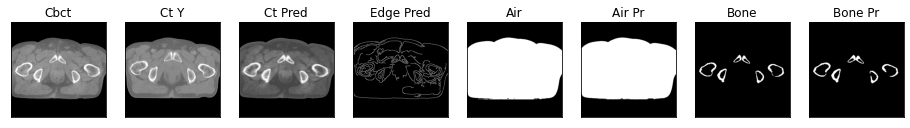

ssim score = 0.7196455001831055
psnr score = 17.13798713684082
snr score = 9.295158386230469
mae error = 0.09363500028848648
air dice score = 0.997817047817049
bone dice score = 0.9012466389647855
contour dice score = 0.6017849445343018


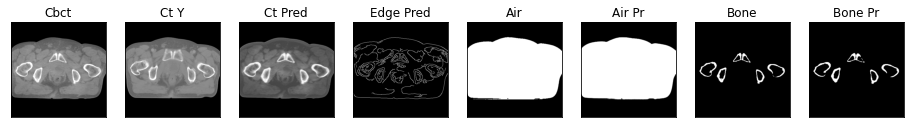

ssim score = 0.708951473236084
psnr score = 17.0388240814209
snr score = 9.238775253295898
mae error = 0.09518355131149292
air dice score = 0.9980806584551906
bone dice score = 0.9018789144061484
contour dice score = 0.5988940596580505


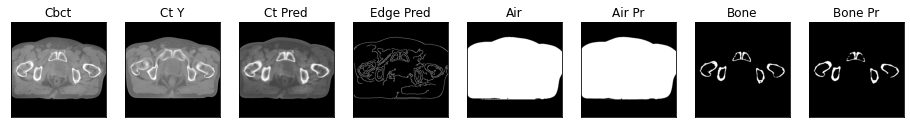

15it [00:39,  2.60s/it]

ssim score = 0.7079437375068665
psnr score = 17.003677368164062
snr score = 9.26196575164795
mae error = 0.09552770107984543
air dice score = 0.998403803311822
bone dice score = 0.8976734166318648
contour dice score = 0.5873808264732361


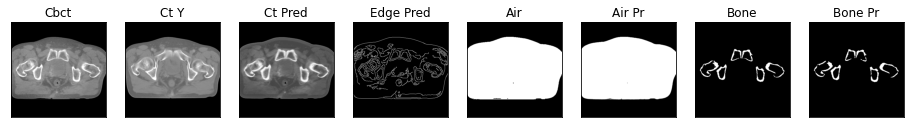

ssim score = 0.7043997645378113
psnr score = 17.058935165405273
snr score = 9.241851806640625
mae error = 0.0950685515999794
air dice score = 0.9988982613186441
bone dice score = 0.8716895914609764
contour dice score = 0.5736433863639832


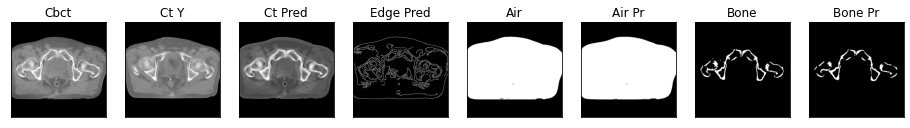

ssim score = 0.7092412114143372
psnr score = 17.295734405517578
snr score = 9.371434211730957
mae error = 0.09163311868906021
air dice score = 0.9989957707602882
bone dice score = 0.8524590163949638
contour dice score = 0.5447897911071777


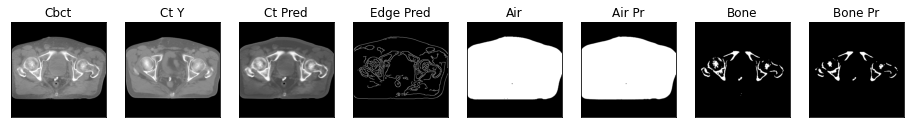

ssim score = 0.7233272790908813
psnr score = 17.696758270263672
snr score = 9.649370193481445
mae error = 0.08683551102876663
air dice score = 0.9988910149224579
bone dice score = 0.8209889422092531
contour dice score = 0.5461220741271973


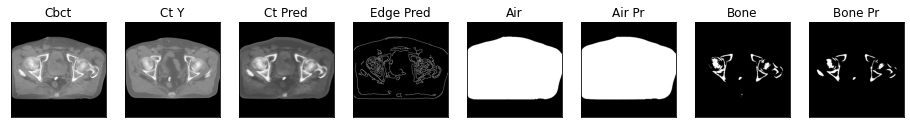

ssim score = 0.729703426361084
psnr score = 18.05027961730957
snr score = 9.890460014343262
mae error = 0.08295483887195587
air dice score = 0.9990782241989198
bone dice score = 0.8691310813695651
contour dice score = 0.547465443611145


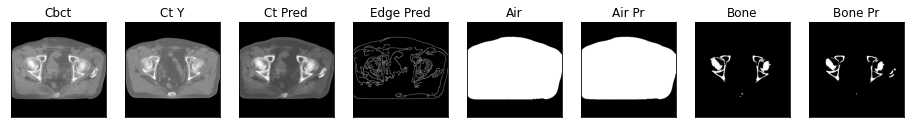

ssim score = 0.7280431985855103
psnr score = 18.308349609375
snr score = 10.097884178161621
mae error = 0.08101383596658707
air dice score = 0.9989659335771194
bone dice score = 0.9183273102744623
contour dice score = 0.5407407283782959


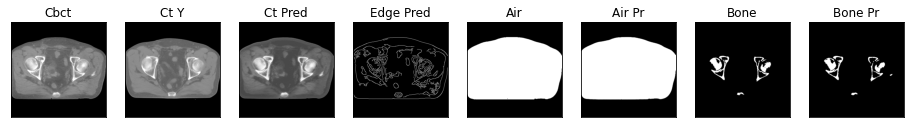

ssim score = 0.7291129231452942
psnr score = 18.161174774169922
snr score = 9.982863426208496
mae error = 0.0818629190325737
air dice score = 0.9989854425499602
bone dice score = 0.9166122360122294
contour dice score = 0.5439330339431763


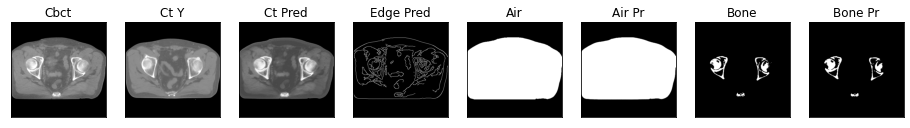

ssim score = 0.7238969206809998
psnr score = 18.016027450561523
snr score = 9.851194381713867
mae error = 0.08273359388113022
air dice score = 0.9989699061276042
bone dice score = 0.9177074822000967
contour dice score = 0.522429883480072


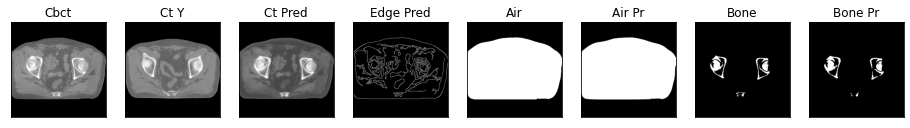

16it [00:41,  2.56s/it]

ssim score = 0.7233898043632507
psnr score = 17.92681884765625
snr score = 9.62049388885498
mae error = 0.08299785107374191
air dice score = 0.9990055571804627
bone dice score = 0.9200047545474859
contour dice score = 0.5030617117881775


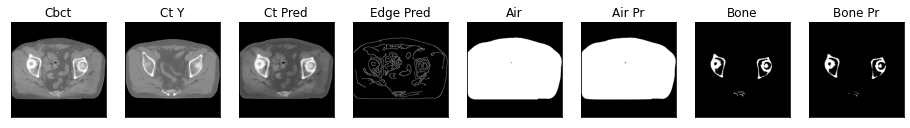

ssim score = 0.7295335531234741
psnr score = 18.053619384765625
snr score = 9.68798542022705
mae error = 0.08077458292245865
air dice score = 0.9990123340662448
bone dice score = 0.9191636702634284
contour dice score = 0.5650733709335327


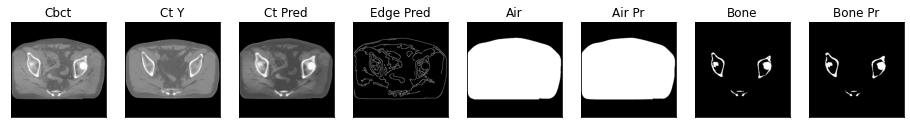

ssim score = 0.7198131680488586
psnr score = 18.280702590942383
snr score = 9.940715789794922
mae error = 0.07823362201452255
air dice score = 0.9989190466345734
bone dice score = 0.87635135135344
contour dice score = 0.5922421813011169


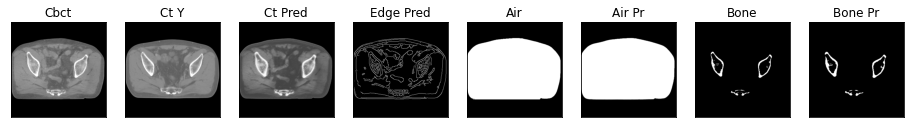

ssim score = 0.7159019708633423
psnr score = 18.036710739135742
snr score = 9.769536972045898
mae error = 0.07963346689939499
air dice score = 0.9987054631828987
bone dice score = 0.8891402714950042
contour dice score = 0.5726455450057983


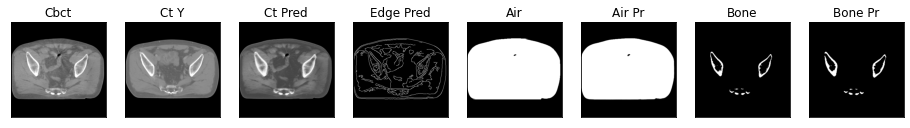

ssim score = 0.7084184288978577
psnr score = 17.551597595214844
snr score = 9.413655281066895
mae error = 0.08394492417573929
air dice score = 0.9987694586812905
bone dice score = 0.9003352636406532
contour dice score = 0.6110581755638123


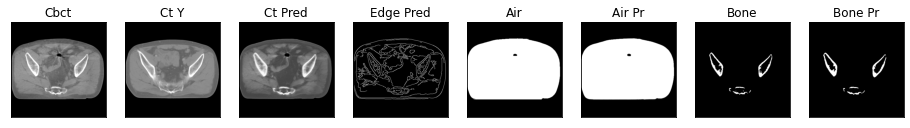

ssim score = 0.705618679523468
psnr score = 17.35403823852539
snr score = 9.250057220458984
mae error = 0.08608586341142654
air dice score = 0.9987801873584153
bone dice score = 0.9043979812558847
contour dice score = 0.5729366540908813


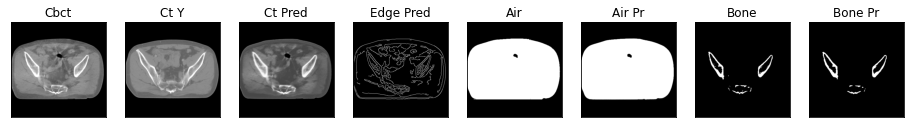

ssim score = 0.6979268789291382
psnr score = 17.292524337768555
snr score = 9.158753395080566
mae error = 0.08776561170816422
air dice score = 0.9987887699084654
bone dice score = 0.9030927835063299
contour dice score = 0.521404504776001


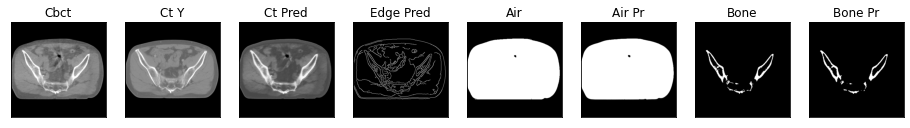

ssim score = 0.6973363757133484
psnr score = 17.586284637451172
snr score = 9.389134407043457
mae error = 0.0845692977309227
air dice score = 0.9987908540198065
bone dice score = 0.8766878980907429
contour dice score = 0.5919845700263977


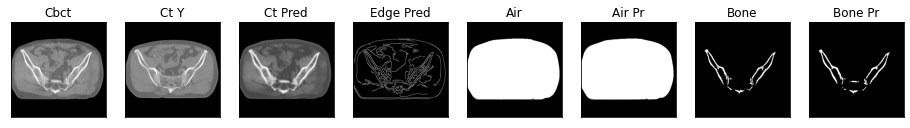

17it [00:44,  2.69s/it]

ssim score = 0.8170760869979858
psnr score = 18.59126853942871
snr score = 10.068656921386719
mae error = 0.07129466533660889
air dice score = 0.9988586674572009
bone dice score = 0.8876811594216463
contour dice score = 0.621730387210846


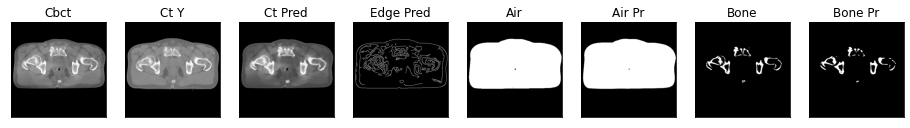

ssim score = 0.8207482695579529
psnr score = 18.598674774169922
snr score = 10.116079330444336
mae error = 0.07135146856307983
air dice score = 0.9988490640291678
bone dice score = 0.8822578639825654
contour dice score = 0.616237998008728


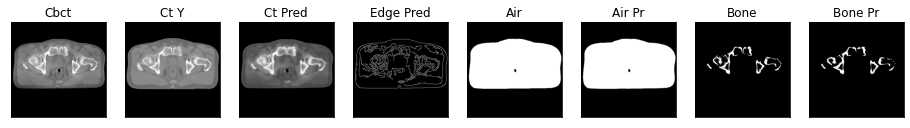

ssim score = 0.8180292248725891
psnr score = 18.59054183959961
snr score = 10.115732192993164
mae error = 0.0712193176150322
air dice score = 0.9989374270874364
bone dice score = 0.8721978871441356
contour dice score = 0.6389873623847961


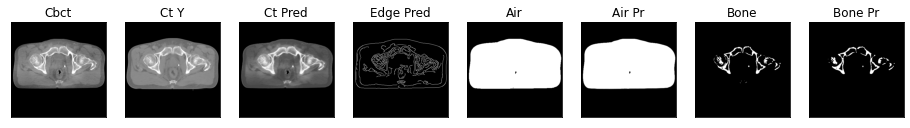

ssim score = 0.822272777557373
psnr score = 18.642126083374023
snr score = 10.108898162841797
mae error = 0.07039494067430496
air dice score = 0.9988814651315405
bone dice score = 0.8813027744284522
contour dice score = 0.6507614254951477


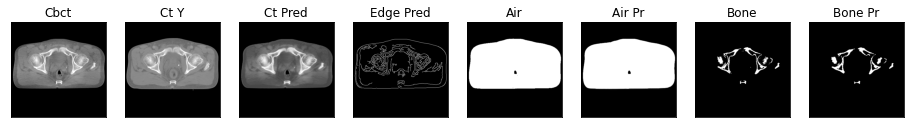

ssim score = 0.8293848037719727
psnr score = 18.973552703857422
snr score = 10.284698486328125
mae error = 0.06705667823553085
air dice score = 0.9988930110100535
bone dice score = 0.858115468411518
contour dice score = 0.6653081774711609


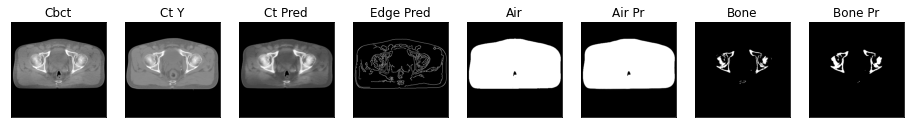

ssim score = 0.8324295878410339
psnr score = 19.056177139282227
snr score = 10.346519470214844
mae error = 0.06651000678539276
air dice score = 0.9984704894433792
bone dice score = 0.8773166275140001
contour dice score = 0.6261491179466248


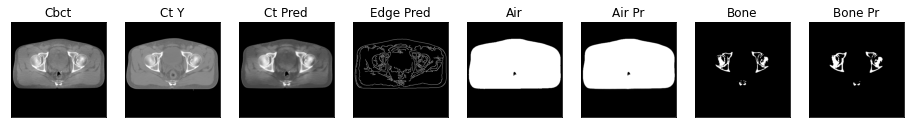

ssim score = 0.8277506232261658
psnr score = 19.0933780670166
snr score = 10.368091583251953
mae error = 0.0659431517124176
air dice score = 0.9983231191487775
bone dice score = 0.8977198697081731
contour dice score = 0.634871780872345


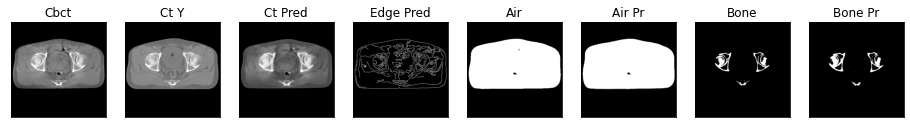

ssim score = 0.8195745944976807
psnr score = 18.906049728393555
snr score = 10.190126419067383
mae error = 0.0667538195848465
air dice score = 0.9983083615273092
bone dice score = 0.9067739771977629
contour dice score = 0.6371590495109558


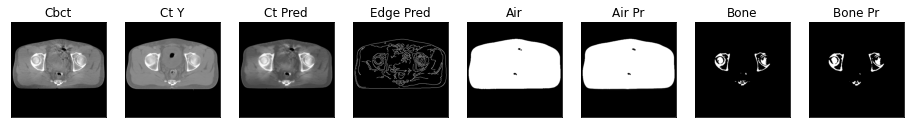

18it [00:47,  2.63s/it]

ssim score = 0.8137341737747192
psnr score = 18.842641830444336
snr score = 10.182499885559082
mae error = 0.06760942935943604
air dice score = 0.9986537792500502
bone dice score = 0.9215738758040475
contour dice score = 0.5715762376785278


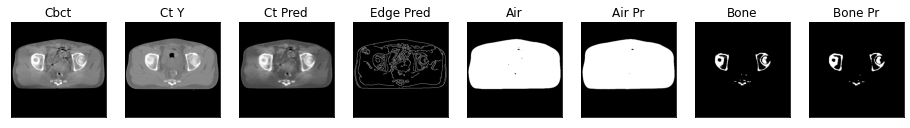

ssim score = 0.8130959868431091
psnr score = 18.730615615844727
snr score = 10.048542976379395
mae error = 0.06821011751890182
air dice score = 0.9983887149241493
bone dice score = 0.9164162797061401
contour dice score = 0.5690550208091736


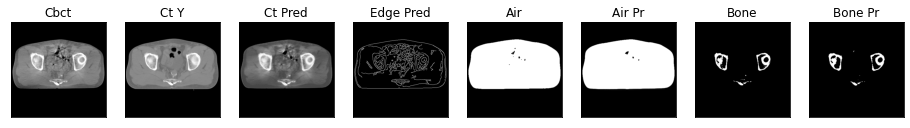

ssim score = 0.812732994556427
psnr score = 18.66922378540039
snr score = 9.916377067565918
mae error = 0.06739764660596848
air dice score = 0.998436153089171
bone dice score = 0.8975868157754917
contour dice score = 0.6225234866142273


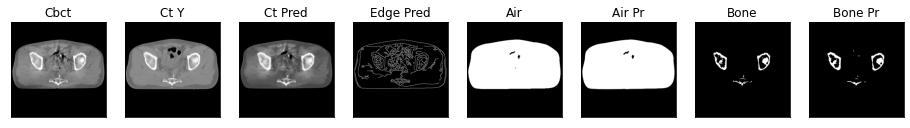

ssim score = 0.8142839670181274
psnr score = 18.87790298461914
snr score = 10.08116340637207
mae error = 0.06573936343193054
air dice score = 0.9986721003708972
bone dice score = 0.89848812095189
contour dice score = 0.6233630180358887


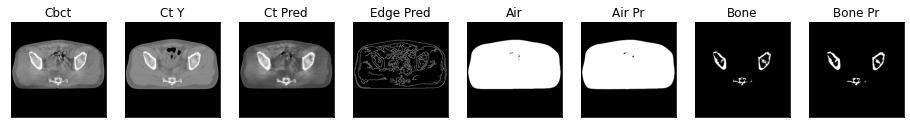

ssim score = 0.8150085806846619
psnr score = 18.95506477355957
snr score = 10.157228469848633
mae error = 0.06521807610988617
air dice score = 0.9984064965908233
bone dice score = 0.9142419601850805
contour dice score = 0.6459758281707764


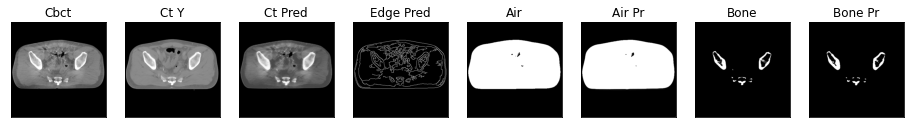

ssim score = 0.8105090260505676
psnr score = 18.9532470703125
snr score = 10.168766975402832
mae error = 0.0652199238538742
air dice score = 0.9980077382829642
bone dice score = 0.920977657820948
contour dice score = 0.6248682737350464


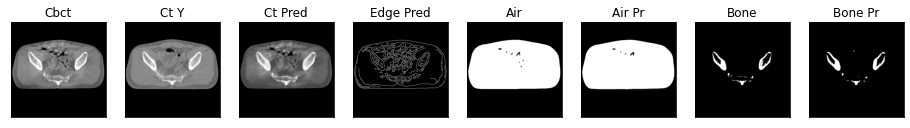

ssim score = 0.8082285523414612
psnr score = 18.76214027404785
snr score = 10.032864570617676
mae error = 0.06712420284748077
air dice score = 0.9981062216416368
bone dice score = 0.9227208435139164
contour dice score = 0.6304118037223816


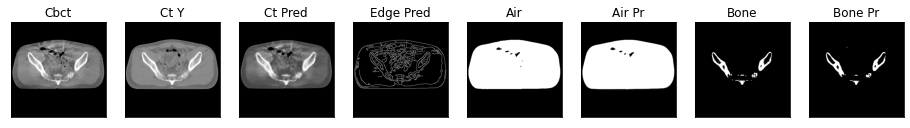

ssim score = 0.8080053329467773
psnr score = 18.567087173461914
snr score = 9.857182502746582
mae error = 0.06811609864234924
air dice score = 0.9981025549678223
bone dice score = 0.9009516150663323
contour dice score = 0.6320804953575134


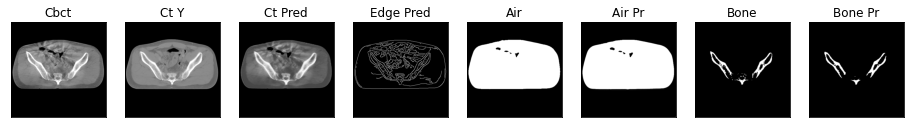

19it [00:49,  2.59s/it]

ssim score = 0.8150472044944763
psnr score = 18.83965492248535
snr score = 10.075011253356934
mae error = 0.06578569859266281
air dice score = 0.9979653569135332
bone dice score = 0.8956028368809135
contour dice score = 0.5580902099609375


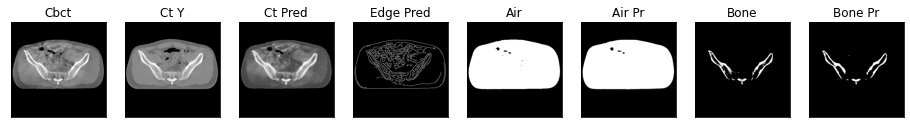

ssim score = 0.8165960907936096
psnr score = 19.089284896850586
snr score = 10.288290023803711
mae error = 0.064220130443573
air dice score = 0.9979666468227906
bone dice score = 0.8876975169316069
contour dice score = 0.5540756583213806


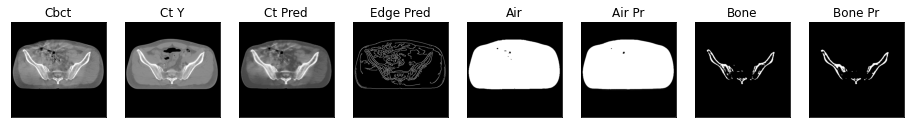

ssim score = 0.8224777579307556
psnr score = 19.21750831604004
snr score = 10.416584968566895
mae error = 0.06351608037948608
air dice score = 0.9979346674195735
bone dice score = 0.8823906630770503
contour dice score = 0.5489566326141357


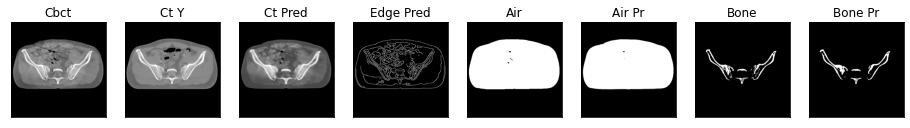

ssim score = 0.8205785155296326
psnr score = 19.316370010375977
snr score = 10.514025688171387
mae error = 0.06260579824447632
air dice score = 0.9983031805679322
bone dice score = 0.8809493099460731
contour dice score = 0.5562130212783813


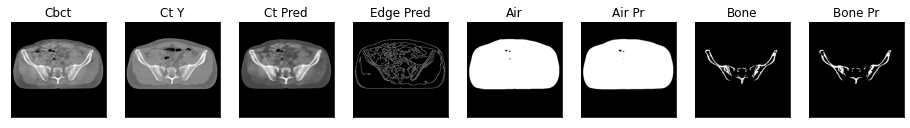

ssim score = 0.8106387257575989
psnr score = 19.04438018798828
snr score = 10.24707317352295
mae error = 0.06401710957288742
air dice score = 0.9981347053611691
bone dice score = 0.8728081654033917
contour dice score = 0.5375878810882568


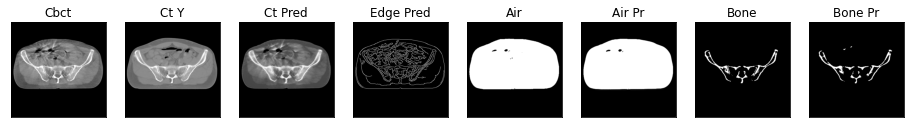

ssim score = 0.805278480052948
psnr score = 18.794815063476562
snr score = 9.980234146118164
mae error = 0.06485860794782639
air dice score = 0.9974292255639705
bone dice score = 0.8591492234995388
contour dice score = 0.5577341914176941


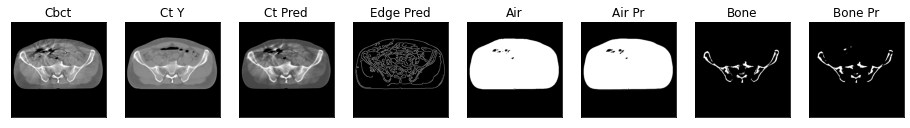

ssim score = 0.8020756244659424
psnr score = 18.72281265258789
snr score = 9.889610290527344
mae error = 0.06525250524282455
air dice score = 0.9979297040417839
bone dice score = 0.8639673010618985
contour dice score = 0.5654794573783875


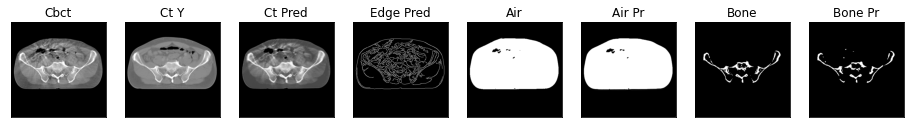

ssim score = 0.7936396598815918
psnr score = 18.61386489868164
snr score = 9.734723091125488
mae error = 0.06542591005563736
air dice score = 0.9973785100805361
bone dice score = 0.8501135503425421
contour dice score = 0.5526751279830933


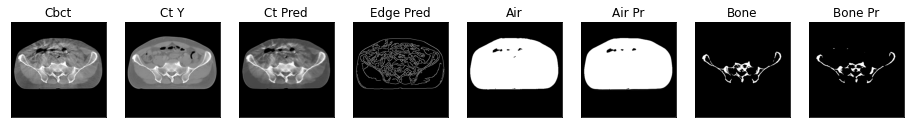

20it [00:52,  2.68s/it]

ssim score = 0.7883899211883545
psnr score = 18.621152877807617
snr score = 9.688213348388672
mae error = 0.06508106738328934
air dice score = 0.99697087132926
bone dice score = 0.8644859813100776
contour dice score = 0.5005549192428589


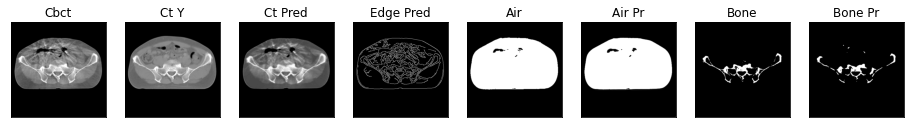

ssim score = 0.7861571907997131
psnr score = 18.413087844848633
snr score = 9.510611534118652
mae error = 0.06702101230621338
air dice score = 0.9964970809007534
bone dice score = 0.8627064333268092
contour dice score = 0.49331849813461304


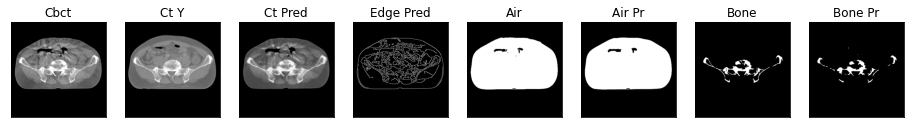

ssim score = 0.7787091135978699
psnr score = 18.395158767700195
snr score = 9.437458038330078
mae error = 0.06600412726402283
air dice score = 0.9969117132032245
bone dice score = 0.8639369277738563
contour dice score = 0.4902723729610443


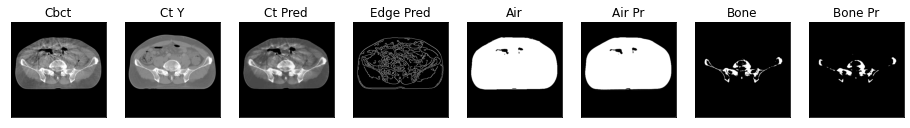

ssim score = 0.7873669862747192
psnr score = 18.942096710205078
snr score = 9.836862564086914
mae error = 0.06200754642486572
air dice score = 0.997076465949195
bone dice score = 0.8792359021342505
contour dice score = 0.3973139226436615


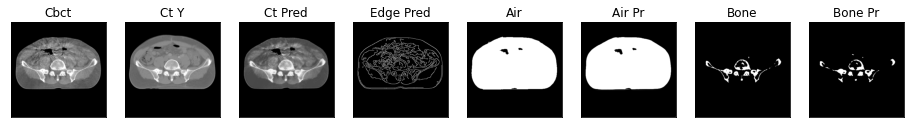

ssim score = 0.8502192497253418
psnr score = 22.22250747680664
snr score = 12.60342025756836
mae error = 0.043058063834905624
air dice score = 0.9964538745659525
bone dice score = 0.8691250903863792
contour dice score = 0.5768298506736755


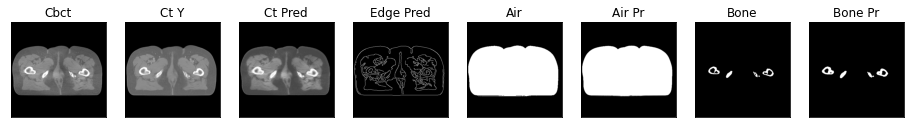

ssim score = 0.8513680100440979
psnr score = 22.09174156188965
snr score = 12.593666076660156
mae error = 0.04486208036541939
air dice score = 0.9968875641711057
bone dice score = 0.8729281767981804
contour dice score = 0.573122501373291


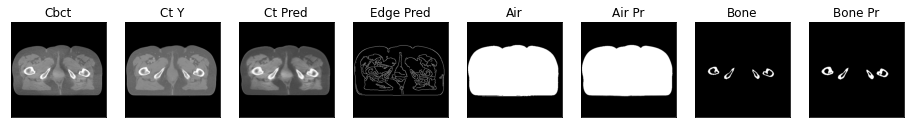

ssim score = 0.8488420844078064
psnr score = 21.923011779785156
snr score = 12.507853507995605
mae error = 0.04644603282213211
air dice score = 0.9971330442122441
bone dice score = 0.8740025978869177
contour dice score = 0.5595703125


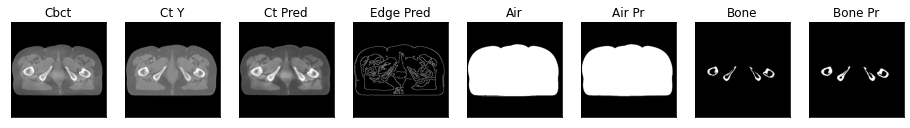

ssim score = 0.8468531966209412
psnr score = 21.789501190185547
snr score = 12.437787055969238
mae error = 0.04754449054598808
air dice score = 0.9973931178310759
bone dice score = 0.8838838838858211
contour dice score = 0.5612493753433228


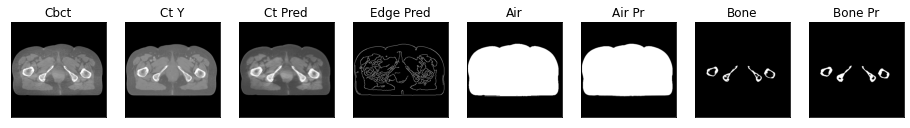

21it [00:55,  2.62s/it]

ssim score = 0.8469915986061096
psnr score = 21.73032569885254
snr score = 12.407073020935059
mae error = 0.04797092452645302
air dice score = 0.9972943918153568
bone dice score = 0.9045764362235544
contour dice score = 0.5555555820465088


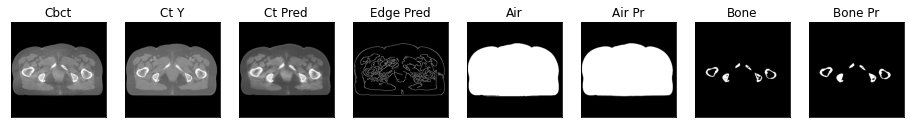

ssim score = 0.8481025695800781
psnr score = 21.70856475830078
snr score = 12.408269882202148
mae error = 0.048077769577503204
air dice score = 0.9972510866123621
bone dice score = 0.9005076142148815
contour dice score = 0.5608568787574768


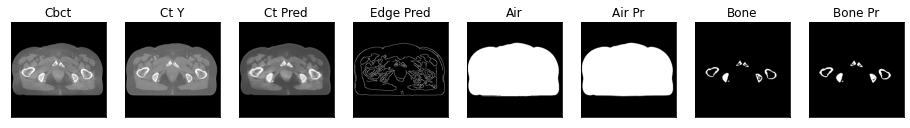

ssim score = 0.8442815542221069
psnr score = 21.597793579101562
snr score = 12.32882308959961
mae error = 0.04871493577957153
air dice score = 0.9971423237646674
bone dice score = 0.899534264805397
contour dice score = 0.5519574880599976


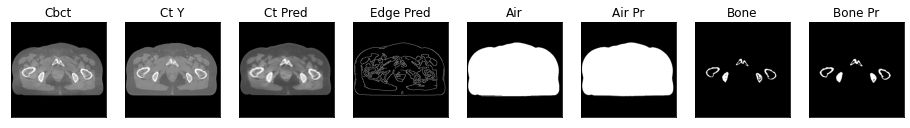

ssim score = 0.8411630392074585
psnr score = 21.43108558654785
snr score = 12.210479736328125
mae error = 0.050112709403038025
air dice score = 0.9971110904020838
bone dice score = 0.8903330625525535
contour dice score = 0.5422932505607605


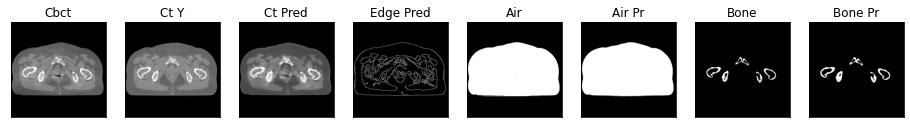

ssim score = 0.8416050672531128
psnr score = 21.21369171142578
snr score = 12.035829544067383
mae error = 0.050993677228689194
air dice score = 0.9971882710736234
bone dice score = 0.8958590852920911
contour dice score = 0.5523535013198853


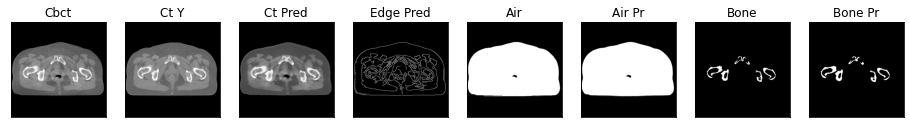

ssim score = 0.8397447466850281
psnr score = 20.980335235595703
snr score = 11.89017391204834
mae error = 0.052669692784547806
air dice score = 0.9968008033856992
bone dice score = 0.8997229916911396
contour dice score = 0.5607476830482483


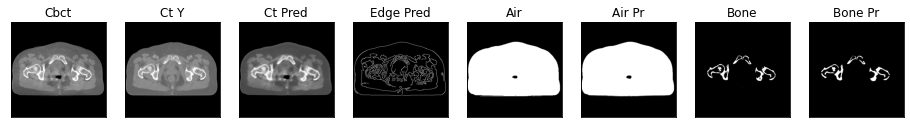

ssim score = 0.8424922823905945
psnr score = 21.00187110900879
snr score = 12.024984359741211
mae error = 0.05413459986448288
air dice score = 0.9964452439076645
bone dice score = 0.8986180750899032
contour dice score = 0.51752769947052


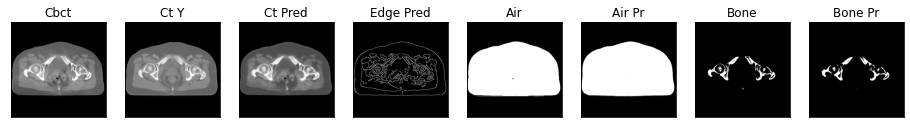

ssim score = 0.8433685898780823
psnr score = 21.068593978881836
snr score = 11.963155746459961
mae error = 0.05189255252480507
air dice score = 0.9966827761731843
bone dice score = 0.8739946380716922
contour dice score = 0.530254065990448


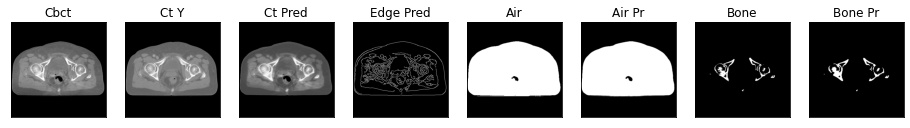

22it [00:57,  2.57s/it]

ssim score = 0.8447825908660889
psnr score = 21.33094024658203
snr score = 12.116080284118652
mae error = 0.049562301486730576
air dice score = 0.9967058958034136
bone dice score = 0.851278483217059
contour dice score = 0.5327102541923523


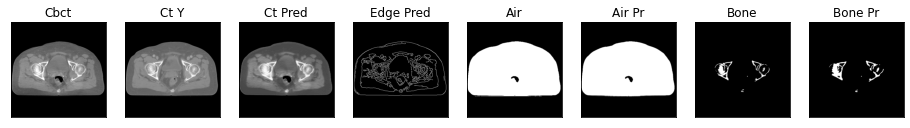

ssim score = 0.8471483588218689
psnr score = 21.501142501831055
snr score = 12.259154319763184
mae error = 0.04822339490056038
air dice score = 0.99648772842233
bone dice score = 0.8798856053403259
contour dice score = 0.5437872409820557


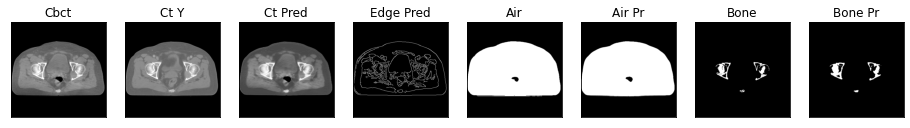

ssim score = 0.8514211773872375
psnr score = 21.91033172607422
snr score = 12.660340309143066
mae error = 0.046866316348314285
air dice score = 0.9968485910516967
bone dice score = 0.8915364381882789
contour dice score = 0.5352638959884644


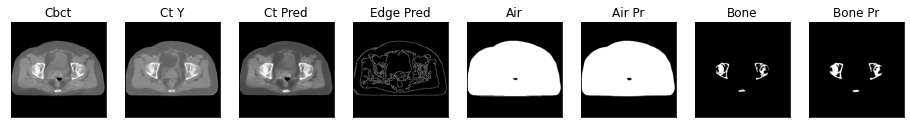

ssim score = 0.8528688549995422
psnr score = 22.129993438720703
snr score = 12.914229393005371
mae error = 0.04689757153391838
air dice score = 0.9969951880984255
bone dice score = 0.9161603888226586
contour dice score = 0.526365339756012


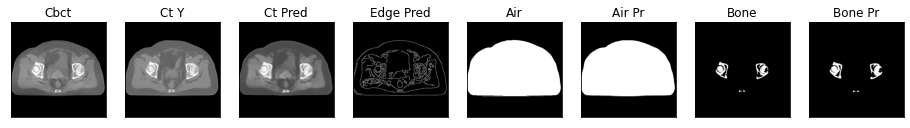

ssim score = 0.8496626615524292
psnr score = 21.890548706054688
snr score = 12.726278305053711
mae error = 0.04874159395694733
air dice score = 0.9975316196051999
bone dice score = 0.9342975842447407
contour dice score = 0.545192301273346


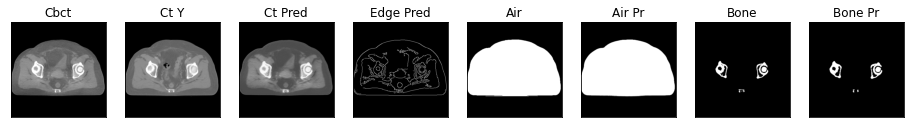

ssim score = 0.8370519876480103
psnr score = 21.575054168701172
snr score = 12.448341369628906
mae error = 0.049742940813302994
air dice score = 0.9976828864614382
bone dice score = 0.9252305665361458
contour dice score = 0.5594202876091003


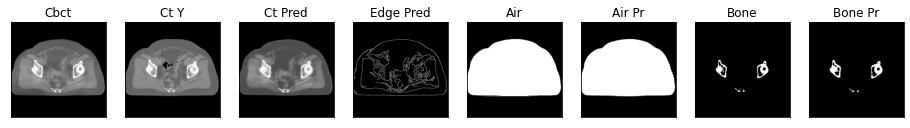

ssim score = 0.8186051249504089
psnr score = 21.034135818481445
snr score = 11.834983825683594
mae error = 0.051393553614616394
air dice score = 0.9975375523270147
bone dice score = 0.858100118252698
contour dice score = 0.5616438388824463


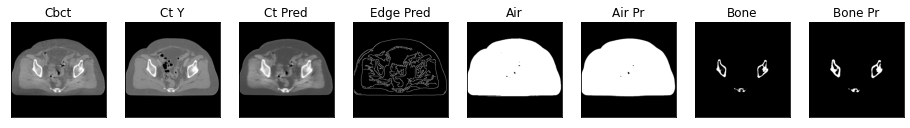

ssim score = 0.8067200779914856
psnr score = 20.772459030151367
snr score = 11.555316925048828
mae error = 0.05210243538022041
air dice score = 0.9976787087902753
bone dice score = 0.8857893672956177
contour dice score = 0.532608687877655


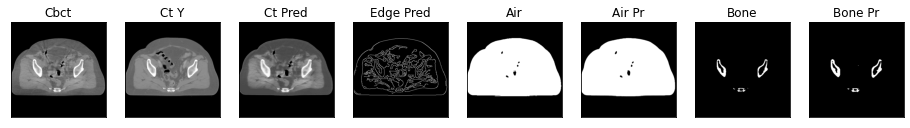

23it [01:00,  2.65s/it]

ssim score = 0.8055298924446106
psnr score = 20.964962005615234
snr score = 11.812732696533203
mae error = 0.05166397988796234
air dice score = 0.9980880313455156
bone dice score = 0.8939334637985532
contour dice score = 0.5461728572845459


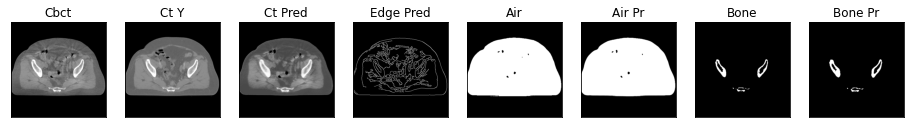

ssim score = 0.8122762441635132
psnr score = 21.122554779052734
snr score = 12.025419235229492
mae error = 0.051584210246801376
air dice score = 0.9980181899468195
bone dice score = 0.9097186259294024
contour dice score = 0.5515181422233582


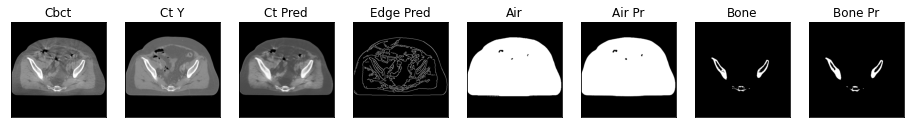

ssim score = 0.8107834458351135
psnr score = 20.842416763305664
snr score = 11.809713363647461
mae error = 0.053682804107666016
air dice score = 0.9979184701085714
bone dice score = 0.9181192324605519
contour dice score = 0.5159705281257629


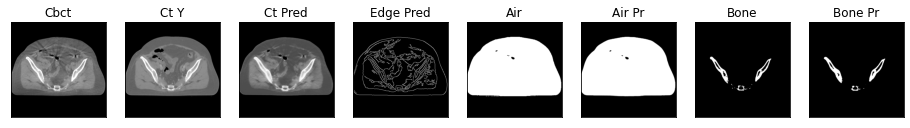

ssim score = 0.8083582520484924
psnr score = 20.632366180419922
snr score = 11.672521591186523
mae error = 0.05525520443916321
air dice score = 0.9981251311097138
bone dice score = 0.9022779350329926
contour dice score = 0.49581074714660645


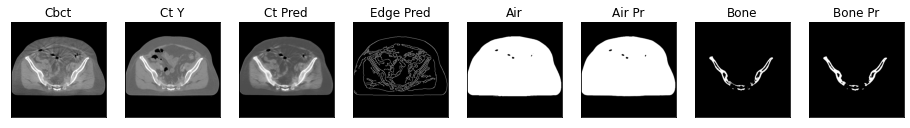

ssim score = 0.809026837348938
psnr score = 20.624252319335938
snr score = 11.660114288330078
mae error = 0.05516005679965019
air dice score = 0.997691612424979
bone dice score = 0.8874746106988832
contour dice score = 0.4885197877883911


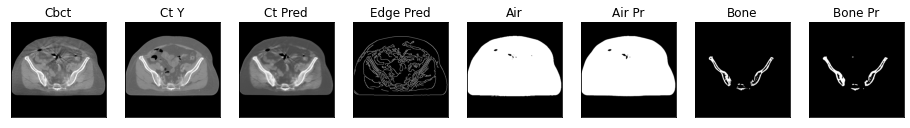

ssim score = 0.8080027103424072
psnr score = 20.718191146850586
snr score = 11.731878280639648
mae error = 0.054932642728090286
air dice score = 0.9980164352507805
bone dice score = 0.8840731070511217
contour dice score = 0.485201358795166


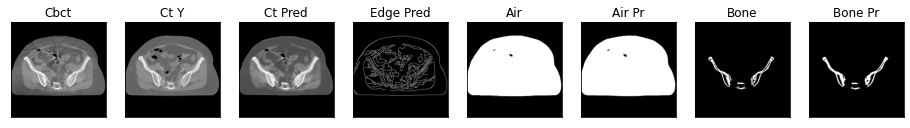

ssim score = 0.8132395148277283
psnr score = 21.08236312866211
snr score = 12.107685089111328
mae error = 0.053601861000061035
air dice score = 0.9979511728099583
bone dice score = 0.8880414056130749
contour dice score = 0.5072324275970459


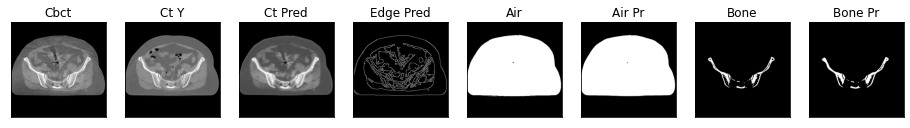

24it [01:02,  2.61s/it]


In [40]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [41]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [42]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [43]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:08,  2.84it/s]


(0.8220216160019239,
 19.827791611353557,
 10.84236212571462,
 0.06073080593099197,
 0.9978331229312486,
 0.8848518508791101,
 0.5843989660290523,
 0.5)

In [44]:
# import torchvision.models as models
# models.vgg16(pretrained=True)